# Проект: Прогнозирование рейтинга отелей на основе отзывов

#### PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle


**ИСХОДНЫЕ ДАННЫЕ:** 

Датасет, в котором содержатся сведения о 515_000 отзывов на отели Европы, первоначальная версия датасета содержит 17 полей со следующей информацией:

***hotel_address*** — адрес отеля;

***review_date*** — дата, когда рецензент разместил соответствующий отзыв;

***average_score*** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

***hotel_name*** — название отеля;

***reviewer_nationality*** — страна рецензента;

***negative_review*** — отрицательный отзыв, который рецензент дал отелю;

***review_total_negative_word_counts*** — общее количество слов в отрицательном отзыв;

***positive_review*** — положительный отзыв, который рецензент дал отелю;

***review_total_positive_word_counts*** — общее количество слов в положительном отзыве.

***reviewer_score*** — оценка, которую рецензент поставил отелю на основе своего опыта;

***total_number_of_reviews_reviewer_has_given*** — количество отзывов, которые рецензенты дали в прошлом;

***total_number_of_reviews*** — общее количество действительных отзывов об отеле;

***tags*** — теги, которые рецензент дал отелю;

***days_since_review*** — количество дней между датой проверки и датой очистки;

***additional_number_of_scoring*** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

***lat*** — географическая широта отеля;

***lng*** — географическая долгота отеля.
***

**ЗАДАНИЕ:**

Обученная модель ***должна предсказывать рейтинг отеля*** по данным сайта Booking на основе имеющихся в датасете данных. 

***

**МЕТРИКА:**

Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 

*** 

**ИНСТРУМЕНТЫ:**

Python,  Pandas, Numpy, Scikit-learn, SciPy, Statsmodels, Matplotlib, Seaborn, Plotly, NLTK, Geopy


***


![](hotels_map.jpeg)

In [196]:
!pip install geopy

In [197]:
!pip install nltk

In [198]:
!pip install folium

In [199]:
!pip install xgboost

In [200]:
!pip install lightgbm

In [201]:
!pip install scikit-learn

In [202]:
#!pip install -U sklearn

In [203]:
# Импорт библиотек
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

from sklearn import preprocessing
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

from xgboost import XGBRegressor

import category_encoders as ce # импорт для работы с кодировщиком

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import re
import requests
import zipfile
import io
import os
import requests
import time

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

import folium

import ast

# import torch

from lightgbm import LGBMRegressor


In [204]:
!pip freeze > requirements.txt

In [205]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Порог отбора признаков низкой значимости
THRESHOLD_QUANTILE = 0.3

# Пороговое значение корреляции для мультиколлинеарности
LIMIT_MULTICOLINEAR_CORR =  0.75

# Требуется ли удалять признаки низкой значимости
INSIGNIFICANT_COLS_DELETE = True


In [206]:
# LightAutoML constant
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600 # equal to 10 minutes
TARGET_NAME = 'reviewer_score'

In [207]:
start_ipynb_time = time.time()

## Загрузка данных

In [208]:
# Загрузка данных из файла hotels.csv
hotels = pd.read_csv('data/hotels.csv')
display(hotels.head())

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review  \
0                     1994                                 Staff were amazing   
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643  
3  48.888697  2.394540  
4  52.385601  4.847060

In [209]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [210]:
hotels.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [211]:
# количество уникальных значений в каждом столбце
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1473
lng                                             1473
dtype: int64

In [212]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропуски NaN в датасете hotel: '

lat    2448
lng    2448
dtype: int64

## Очистка пропущенных значений

Проверим наличие в датасете Nan и скрытых пустых значений (пустые строки и строки с пробелами)

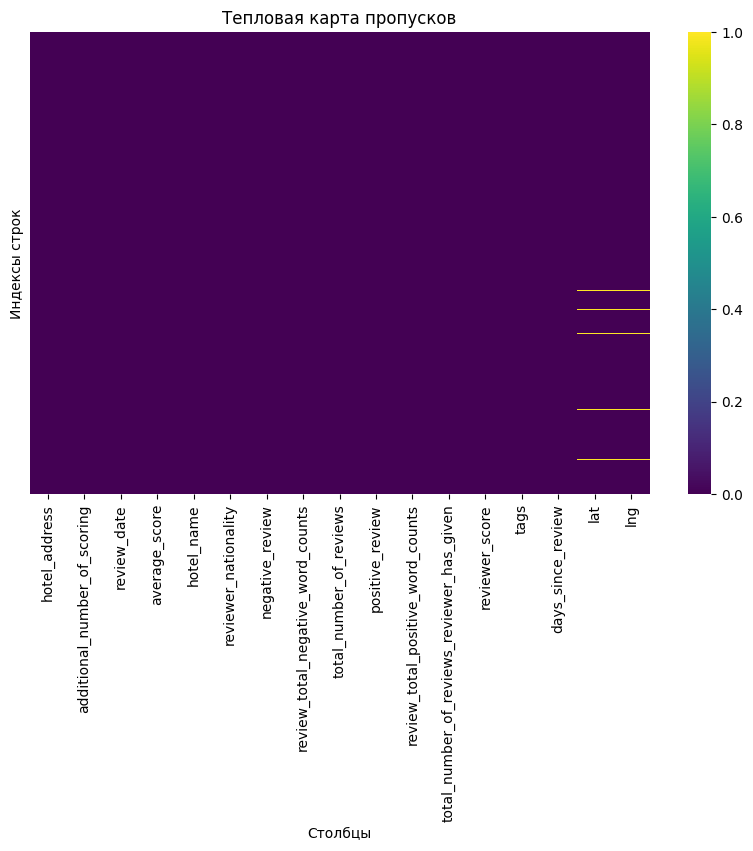

'Столбцы датасета с пропусками (NaN и неявные пропуски) :'

reviewer_nationality     395
negative_review          606
positive_review          128
lat                     2448
lng                     2448
dtype: int64

In [213]:
# Проверяем наличие неявных пропусков в датасете, заменяем пустые строки и строки с пробелами на NaN
# Действие производим над копией датасета
df = hotels.copy()
df= df.replace(['', ' ', '  '], np.nan)

# Визуализация пропусков
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap='viridis', cbar=True, yticklabels=False)

# Настраиваем график
plt.title('Тепловая карта пропусков')
plt.xlabel('Столбцы')
plt.ylabel('Индексы строк')
plt.show()

# Подсчет NaN значений в каждом столбце
nan_counts = df.isna().sum()

# Фильтруем только те столбцы, где есть NaN значения
nan_columns = nan_counts[nan_counts > 0]
    
# Проверяем, есть ли пропуски
if nan_columns.any():  # Проверяем, есть ли хотя бы один пропуск
    display("Столбцы датасета с пропусками (NaN и неявные пропуски) :")
    display(nan_columns)
else:
    display('Пропусков (NaN и неявных пропусков) в датасете нет')


Заполняем пустые значения признака reviewer_nationality модой

In [214]:
# Заменяем пустые строки и строки с пробелами на NaN
hotels['reviewer_nationality']= hotels['reviewer_nationality'].replace(['', ' '], np.nan)
display(f"Количество пустых значений в reviewer_nationality ДО обработки {hotels['reviewer_nationality'].isna().sum()}")

# Заполняем NaN наиболее частым значением (модой)
most_frequent_nationality = hotels['reviewer_nationality'].mode()[0]
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].fillna(most_frequent_nationality)
display(f"Количество пустых значений в reviewer_nationality ПОСЛЕ обработки {hotels['reviewer_nationality'].isna().sum()}")

'Количество пустых значений в reviewer_nationality ДО обработки 395'

'Количество пустых значений в reviewer_nationality ПОСЛЕ обработки 0'

Признаки negative_review и positive_review будут использованы для создания новых признаков, заполнение пропущенных значений на данном этапе - не требуется.

#### Заполняем пропущенные значения в признаках lat и lng через геокодер geopy, используя адрес отеля

Чтобы заполнить пропущенные значения в столбцах lat и lng на основе адреса отеля из столбца hotel_address, используем геокодирование. Для этого воспользуемся библиотекой geopy, которая позволяет преобразовывать адреса в координаты (широту и долготу).

In [215]:
# Создаем экземпляр геокодера
geolocator = Nominatim(user_agent="hotel_locator", timeout=10)  # Увеличиваем таймаут до 10 секунд

# Функция для геокодирования адреса отеля
def get_lat_lng(address):
    try:
        location = geolocator.geocode(address, timeout=10)  # Увеличиваем таймаут
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return get_lat_lng(address)  # Повторяем запрос в случае таймаута
    except Exception as e:
        display(f"Ошибка при геокодировании адреса '{address}': {e}")
        return None, None

# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Заполняем пропущенные значения
for index, row in grouped_missing_geo.iterrows():
    lat, lng = get_lat_lng(row['hotel_address'])  # Используем адрес отеля
    # Находим все индексы отелей с этим именем и заполняем lat и lng
    hotels.loc[hotels['hotel_name'] == row['hotel_name'], ['lat', 'lng']] = lat, lng
    
    # Вычисляем процент выполнения
    percent_complete = (index + 1) / len(grouped_missing_geo) * 100
    print(f"Заполнено: {percent_complete:.2f}% ({index + 1}/{len(grouped_missing_geo)})", end='\r')  # Обновляем строку

    time.sleep(0.5)  # Задержка в 0,5 секунды между запросами

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')


'Количество пропусков в lat: 2448'

'Количество пропусков в lng: 2448'

In [216]:
# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name
grouped_missing_geo = missing_geo.groupby('hotel_name').size().reset_index(name='missing_count')
# Группируем по hotel_name и hotel_address
#grouped_missing_geo = missing_geo.groupby(['hotel_name', 'hotel_address']).size().reset_index(name='missing_count')

# Проверяем результат
display(grouped_missing_geo)

hotel_name  missing_count
0   Austria Trend Hotel Schloss Wilhelminenberg Wien            141
1                          City Hotel Deutschmeister             63
2                          Cordial Theaterhotel Wien             40
3       Derag Livinghotel Kaiser Franz Joseph Vienna            112
4                Fleming s Selection Hotel Wien City            496
5                       Holiday Inn Paris Montmartre             47
6                                      Hotel Advance             26
7                                      Hotel Atlanta            285
8                                 Hotel City Central            421
9                                Hotel Daniel Vienna            182
10                                  Hotel Park Villa             44
11                Hotel Pension Baron am Schottentor            172
12            Maison Albar Hotel Paris Op ra Diamond            224
13                   Mercure Paris Gare Montparnasse             28
14                    NH Collection Barcelona Podium            113
15                       Renaissance Barcelona Hotel             20
16                                      Roomz Vienna             34

In [217]:
# Создаем экземпляр геокодера   
geolocator = Nominatim(user_agent="hotel_locator", timeout=10)  # Увеличиваем таймаут до 10 секунд

# Функция для геокодирования отеля по его на
def get_lat_lng_name(hotel_name):
    try:
        location = geolocator.geocode(hotel_name, timeout=10)  # Увеличиваем таймаут
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return get_lat_lng(hotel_name)  # Повторяем запрос в случае таймаута
    except Exception as e:
        display(f"Ошибка при геокодировании адреса '{hotel_name}': {e}")
        return None, None

# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Заполняем пропущенные значения
for index, row in grouped_missing_geo.iterrows():
    lat, lng = get_lat_lng_name(row['hotel_address'])  # Используем адрес отеля
    # Находим все индексы отелей с этим именем и заполняем lat и lng
    hotels.loc[hotels['hotel_name'] == row['hotel_name'], ['lat', 'lng']] = lat, lng
    
    # Вычисляем процент выполнения
    percent_complete = (index + 1) / len(grouped_missing_geo) * 100
    print(f"Заполнено: {percent_complete:.2f}% ({index + 1}/{len(grouped_missing_geo)})", end='\r')  # Обновляем строку

    time.sleep(0.5)  # Задержка в 0,5 секунды между запросами

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')


'Количество пропусков в lat: 2448'

'Количество пропусков в lng: 2448'

In [218]:
# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name
grouped_missing_geo = missing_geo.groupby('hotel_name').size().reset_index(name='missing_count')

# Проверяем результат
display(grouped_missing_geo)

hotel_name  missing_count
0   Austria Trend Hotel Schloss Wilhelminenberg Wien            141
1                          City Hotel Deutschmeister             63
2                          Cordial Theaterhotel Wien             40
3       Derag Livinghotel Kaiser Franz Joseph Vienna            112
4                Fleming s Selection Hotel Wien City            496
5                       Holiday Inn Paris Montmartre             47
6                                      Hotel Advance             26
7                                      Hotel Atlanta            285
8                                 Hotel City Central            421
9                                Hotel Daniel Vienna            182
10                                  Hotel Park Villa             44
11                Hotel Pension Baron am Schottentor            172
12            Maison Albar Hotel Paris Op ra Diamond            224
13                   Mercure Paris Gare Montparnasse             28
14                    NH Collection Barcelona Podium            113
15                       Renaissance Barcelona Hotel             20
16                                      Roomz Vienna             34

#### Если координаты для этих отелей из списка не были найдены через геокодер geopy - используем альтернативный геокодер photon

In [219]:
# Заполняем пропущенные значения через геокодер Photon
def get_lat_lng_photon(address):
    url = f"https://photon.komoot.io/api/?q={address}"

    response = requests.get(url)
    if response.status_code == 200:
        results = response.json()
        if results['features']:
            location = results['features'][0]['geometry']['coordinates']
            return location[1], location[0]  # Возвращаем (широта, долгота)
    return None, None

# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Заполняем пропущенные значения
for index, row in grouped_missing_geo.iterrows():
    lat, lng = get_lat_lng_photon(row['hotel_address'])  # Используем адрес отеля
    # Находим все индексы отелей с этим именем и заполняем lat и lng
    hotels.loc[hotels['hotel_name'] == row['hotel_name'], ['lat', 'lng']] = lat, lng
    
    # Вычисляем процент выполнения
    percent_complete = (index + 1) / len(grouped_missing_geo) * 100
    print(f"Заполнено: {percent_complete:.2f}% ({index + 1}/{len(grouped_missing_geo)})", end='\r')  # Обновляем строку

    time.sleep(0.5)  # Задержка в 0.5 секунды между запросами

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')
# ожидание 2-3 минуты - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

'Количество пропусков в lat: 1990'

'Количество пропусков в lng: 1990'

##### Проверка списка отелей с пропущенными значениями в lat и lng

In [220]:
# Создаем датафрейм с пропущенными значениями в lat и lng
missing_geo = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]

# Группируем по hotel_name и получаем адреса
grouped_missing_geo = missing_geo.groupby('hotel_name').agg({'hotel_address': 'first'}).reset_index()

# Проверяем результат
grouped_missing_geo

hotel_name  \
0   Austria Trend Hotel Schloss Wilhelminenberg Wien   
1                          City Hotel Deutschmeister   
2                          Cordial Theaterhotel Wien   
3       Derag Livinghotel Kaiser Franz Joseph Vienna   
4                Fleming s Selection Hotel Wien City   
5                                      Hotel Atlanta   
6                                 Hotel City Central   
7                                Hotel Daniel Vienna   
8                                   Hotel Park Villa   
9                 Hotel Pension Baron am Schottentor   
10                                      Roomz Vienna   

                                        hotel_address  
0    Savoyenstra e 2 16 Ottakring 1160 Vienna Austria  
1   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  
2   Josefst dter Stra e 22 08 Josefstadt 1080 Vien...  
3   Sieveringer Stra e 4 19 D bling 1190 Vienna Au...  
4   Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  
5   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  
6   Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  
7   Landstra er G rtel 5 03 Landstra e 1030 Vienna...  
8   Hasenauerstra e 12 19 D bling 1190 Vienna Austria  
9   W hringer Stra e 12 09 Alsergrund 1090 Vienna ...  
10   Paragonstra e 1 11 Simmering 1110 Vienna Austria

##### Если координаты для этих отелей из списка не были найдены через геокодеры geopy и photon - используем словарь с координатами отелей для заполнения.

In [221]:
# Заполняем пропущенные значения через словарь
start_time = time.time()

coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

def get_coord(row):
    if pd.isna(row.lat):
        row.lat = coord_dict[row.hotel_name][0]
        row.lng = coord_dict[row.hotel_name][1]
        return row
    else: 
        return row

hotels = hotels.apply(lambda row: get_coord(row), axis=1)

#start_time = time.time()
display("--- %s seconds ---" % (time.time() - start_time))

# Проверяем наличие пропусков в lat и lng
display(f'Количество пропусков в lat: {int(hotels["lat"].isna().sum())}')
display(f'Количество пропусков в lng: {int(hotels["lng"].isna().sum())}')
# ожидание 15-20 секунд - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

'--- 20.4115629196167 seconds ---'

'Количество пропусков в lat: 0'

'Количество пропусков в lng: 0'

### Отображение отелей на карте

In [222]:
# Удаляем строки с NaN значениями в копии датасета
df = hotels.copy()
df = df.dropna(subset=['lat', 'lng']).copy()

# Группируем по названию отеля и берем средние координаты
grouped_hotels = df.groupby('hotel_name', as_index=False).agg({'lat': 'mean', 'lng': 'mean'})

# Создаем карту с начальным центром
map_center = [0, 0]  # Центр карты (широта, долгота)
hotel_map = folium.Map(location=map_center, zoom_start=2)

# Добавляем точки отелей на карту
for index, row in grouped_hotels.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=row['hotel_name'],  # Подсказка с названием отеля
        icon=folium.Icon(color='blue')  # Цвет маркера
    ).add_to(hotel_map)

# Сохраняем карту в HTML файл
hotel_map.save('hotels_map.html')

# Отображаем карту (в Jupyter Notebook)
hotel_map

# ожидание около 2-5 секунд - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

In [223]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

In [224]:
# сохраняем датафрейм с без пропусков
#hotels.to_csv('data/hotels_without_nan.csv', index=False)

## Создание новых признаков


#### Исходя из анализа данных, содержащихся с столбце 'tags' - cоздаем новые бинарные признаки (признак есть - 1, признака нет - 0). 

1. Признак на основе типа путешествия

    - 'Leisure trip'

    - 'Business trip'

2. Способ бронирования

    - 'Submitted from a mobile device'

3. Признак на основе кол-ва посетителей отеля в группе.

    - 'Solo traveler'
  
    - 'Couple'
  
    - 'Group'
  
    - 'Family with young children'
  
    - 'Family with older children'

Предполагаем, что эти данные улучшают точность создаваемой модели.

In [225]:
hotels['leisure_trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['business_trip'] = hotels['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
hotels['mobile_booking'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['solo_traveler'] = hotels['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
hotels['couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
hotels['group'] = hotels['tags'].apply(lambda x: 1 if 'Group' in x else 0)
hotels['family_with_young_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)
hotels['family_with_older_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)

### Создание признака количества ночей пребывания в отеле (stayed_nights) на основе данных столбца tags


In [226]:
# Создаем новую колонку stayed_nights, извлекая числовое значение перед словом "night"
hotels['stayed_nights'] = hotels['tags'].str.extract(r'(\d+)\s*night', expand=False)

# Преобразуем в числовой формат
hotels['stayed_nights'] = pd.to_numeric(hotels['stayed_nights'], errors='coerce')

# Заполнение пропущенных значений медианой
hotels['stayed_nights'] = hotels['stayed_nights'].fillna(hotels['stayed_nights'].median())

### Создание признака страны отеля (hotel_country) на основании адреса отеля


Выделяем признак страны отеля на основании адреса отеля

In [227]:
# URL к ZIP-архиву со списком стран
url = 'https://cdn-std.droplr.net/files/acc_432097/8xjTtQ?download&response-content-disposition=attachment%3B%20filename%3Dcountry-city-and-state-csv.zip'

# Загружаем ZIP-архив
response = requests.get(url)
display(f'Country database download response status code: {response.status_code}')

# Проверяем, что запрос успешен
if response.status_code == 200:
    # Открываем ZIP-архив
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Извлекаем файл countries.csv
        with z.open('countries.csv') as f:
            # Загружаем данные в DataFrame
            countries_df = pd.read_csv(f)
            # Извлекаем первую колонку с названиями стран
            country_names = countries_df.iloc[:, 0].tolist()
            #display(country_names)
else:
    display(f"Ошибка загрузки: {response.status_code}")

# формирваем список стран
if not country_names: 
    countries = country_names
else:
    countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 
                 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 
                 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 
                 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 
                 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 
                 'Chad', 'Chile', "People's Republic of China", 'Colombia', 'Comoros', 'Congo - Kinshasa', 
                 'Congo - Brazzaville', 'Costa Rica', "Cote d'Ivoire (The Ivory Coast)", 'Croatia', 'Cuba', 
                 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 
                 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 
                 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 
                 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 
                 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 
                 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'North Korea', 
                 'South Korea', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 
                 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Madagascar', 'Malawi', 
                 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 
                 'Mexico', 'Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 
                 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 
                 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 
                 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 
                 'Romania', 'Russia', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 
                 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 
                 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 
                 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'Spain', 
                 'Sri Lanka', 'Sudan', 'Suriname', 'Swaziland', 'Sweden', 'Switzerland', 'Syria', 
                 'Tajikistan', 'Tanzania', 'Thailand', 'Timor-Leste (East Timor)', 'Togo', 'Tonga', 
                 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 
                 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay', 'Uzbekistan', 
                 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe', 
                 'Abkhazia', 'Taiwan', 'Nagorno-Karabakh', 'Northern Cyprus', 'Pridnestrovie (Transnistria)', 
                 'Somaliland', 'South Ossetia', 'Ashmore and Cartier Islands', 'Christmas Island', 
                 'Cocos (Keeling) Islands', 'Coral Sea Islands', 'Heard Island and McDonald Islands', 
                 'Norfolk Island', 'New Caledonia', 'French Polynesia', 'Mayotte', 'Saint Barthelemy', 
                 'Saint Martin', 'Saint Pierre and Miquelon', 'Wallis and Futuna', 
                 'French Southern and Antarctic Lands', 'Clipperton Island', 'Bouvet Island', 
                 'Cook Islands', 'Niue', 'Tokelau', 'Guernsey', 'Isle of Man', 'Jersey', 'Anguilla', 
                 'Bermuda', 'British Indian Ocean Territory', 'British Sovereign Base Areas', 
                 'British Virgin Islands', 'Cayman Islands', 'Falkland Islands (Islas Malvinas)', 
                 'Gibraltar', 'Montserrat', 'Pitcairn Islands', 'Saint Helena', 
                 'South Georgia & South Sandwich Islands', 'Turks and Caicos Islands', 
                 'Northern Mariana Islands', 'Puerto Rico', 'American Samoa', 'Baker Island', 
                 'Guam', 'Howland Island', 'Jarvis Island', 'Johnston Atoll', 'Kingman Reef', 
                 'Midway Islands', 'Navassa Island', 'Palmyra Atoll', 'U.S. Virgin Islands', 
                 'Wake Island', 'Hong Kong', 'Macau', 'Faroe Islands', 'Greenland', 'French Guiana', 
                 'Guadeloupe', 'Martinique', 'Reunion', 'Aland', 'Aruba', 'Netherlands Antilles', 
                 'Svalbard', 'Ascension', 'Tristan da Cunha', 'Australian Antarctic Territory', 
                 'Ross Dependency', 'Peter I Island', 'Queen Maud Land', 'British Antarctic Territory']
    

# Функция для извлечения страны из адреса
def extract_country(address):
    # Проверяем каждую страну в списке
    for country in countries:
        if country in address:
            return country
    return None

# Применяем функцию к датафрейму
hotels['hotel_country'] = hotels['hotel_address'].apply(extract_country)

# Заполнение пропущенных значений модой
hotels['hotel_country'] = hotels['hotel_country'].fillna(hotels['hotel_country'].mode()[0])
# ожидание 6-10 секунд - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

'Country database download response status code: 200'

In [228]:
hotels['hotel_country'].value_counts()

hotel_country
United Kingdom    196774
France             44830
Spain              44643
Netherlands        43006
Austria            29178
Italy              27883
Nicaragua            292
Palau                197
Name: count, dtype: int64

Дополнительная проверка на пропуски значений

In [229]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

In [230]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

#### Создаем признаки на основе даты отзыва (review_date)

In [231]:
#Преобразуем признак review_date в признаки на основе даты отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day

#Преобразуем признак review_date в признак сезона весна (1), лето (2), осень (3), зима (4)
hotels['season'] = hotels['review_month'].apply(lambda x: 1 if x in [3, 4, 5] else
                                              2 if x in [6, 7, 8] else
                                              3 if x in [9, 10, 11] else
                                              4 if x in [12, 1, 2] else
                                              0)
#Преобразуем признак review_date в  признак дня недели
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek

Гипотеза - возможно есть влияние на точность модели признака, описывающего совпадение страны отеля и страны рецензента.
После проверки получены данные - о том, что внутрение путешествия составляют 0,1% от всей выборки. Использование такого признака лишено смысла.

In [232]:
# Проверяем, совпадает ли страна рецензента с названием страны в адресе отеля и присваиваем 1 или 0
# hotels['reviewer_abroad'] = hotels.apply(lambda row: 0 if row['reviewer_nationality'] == row['hotel_country'] else 1, axis=1)

# Создаем новый столбец с учетом NaN
hotels['reviewer_abroad'] = np.where(
    (hotels['reviewer_nationality'].isna()) | (hotels['hotel_country'].isna()), 
    np.nan,  # Если есть NaN, ставим NaN в новый столбец
    np.where(hotels['reviewer_nationality'] == hotels['hotel_country'], 0, 1)
)

# неважный признак, внутрение путешествия составляют 0,1% от всей выборки

In [233]:
# Проверяем, превышает ли одно из значений 95% от общего количества
threshold = 0.95 * len(hotels)

# Подсчитываем количество значений в столбце 'reviewer_abroad'
value_counts = hotels['reviewer_abroad'].value_counts()

# Проверяем, есть ли значение, которое превышает 90%
if (value_counts.max() > threshold):
    # Удаляем столбец 'reviewer_abroad'
    hotels.drop(columns=['reviewer_abroad'], inplace=True)
    print("Столбец 'reviewer_abroad' был удален, так как одно из значений превышает в нем 95%.")
else:
    print("Столбец 'reviewer_abroad' не был удален.")

Столбец 'reviewer_abroad' был удален, так как одно из значений превышает в нем 95%.


#### Преобразование признака days_since_review из строкового в числовой признак

In [234]:
# Преобразуем признак days_since_review в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

#### Кодирование признака reviewer_nationality бинарным способом BinaryEncoder

In [235]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

#### Кодирование признака hotel_country бинарным способом BinaryEncoder

In [236]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_country']) 
type_bin = bin_encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [237]:
# модель на признаках с dtypes "object" обучаться не будет, выберем их для проверки
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
display(object_columns)

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'hotel_country']

In [238]:
# список колонок датафрейма
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'leisure_trip', 'business_trip',
       'mobile_booking', 'solo_traveler', 'couple', 'group',
       'family_with_young_children', 'family_with_older_children',
       'stayed_nights', 'hotel_country', 'review_year', 'review_month',
       'review_day', 'season', 'day_of_week', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7', 'hotel_country_0', 'hotel_country_1',
       'hotel_country_2', 'hotel_

In [239]:
# информация о датафрейме
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [240]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

### Решение заданий по разделу 4 (на выполнение проекта не влияет)
Нужно для анализа возможность сформировать новые признаки

In [241]:
display(f'Количество уникальных отелей: {hotels["hotel_name"].nunique()}')
display(f'Дата начала отзывов: {hotels["review_date"].min()}')  
display(f'Дата окончания отзывов: {hotels["review_date"].max()}')

'Количество уникальных отелей: 1492'

'Дата начала отзывов: 2015-08-04 00:00:00'

'Дата окончания отзывов: 2017-08-03 00:00:00'

In [242]:
# выполнение задания по блоку 4
# Копирууем датасет для применения explode()
df = hotels.copy()

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

df['tags_n'] = df['tags'].apply(rev_func)
df.head()
display(f'Количество уникальных тегов: {df["tags_n"].explode().nunique()}')

'Количество уникальных тегов: 2368'

Это задание интересно тем, что есть несколько значений, похожих на night /  nights - Knight, или night относящийся к названию номера, без численного значения количества ночей перед ним.

In [243]:
# Фильтруем теги, содержащие слово "night"
# Используем explode и регулярное выражение для поиска 'night' или 'nights' перед которыми стоит число
night_tags = df['tags_n'].explode()[df['tags_n'].explode().str.contains(r'\b\d+\s+(night|nights)\b', case=False, regex=True)]

#night_tags = df['tags_n'].explode().str.extract(r'(\b\d+\s+(night|nights)\b)', flags=re.IGNORECASE)

# Получаем распределение по количества ночей пребывания в отеле
night_counts = night_tags.value_counts()
display(f'Распределение по количеству ночей пребывания в отеле:')
display(night_counts)

C:\Users\stepu\AppData\Local\Temp\ipykernel_55080\3746712949.py:3: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



'Распределение по количеству ночей пребывания в отеле:'

tags_n
Stayed 1 night                                145373
Stayed 2 nights                               100263
Stayed 3 nights                                72000
Stayed 4 nights                                35748
Stayed 5 nights                                15611
Stayed 6 nights                                 7399
Stayed 7 nights                                 5549
Stayed 8 nights                                 1910
Stayed 9 nights                                  966
Stayed 10 nights                                 663
Stayed 11 nights                                 306
Stayed 12 nights                                 217
Stayed 14 nights                                 184
Stayed 13 nights                                 174
Stayed 15 nights                                  87
Stayed 16 nights                                  38
Stayed 17 nights                                  27
Stayed 18 nights                                  24
Stayed 19 nights                       

In [244]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

### Создаем новый признак stayed_nights, извлекая из признака tags числовое значение перед словом "night" или "nights"

In [245]:
# Создаем новую колонку stayed_nights, извлекая числовое значение перед словом "night" или "nights"
# Применяем explode для разбивки списка на отдельные строки
exploded_hotels = hotels.explode('tags')

# Извлекаем число перед 'night' или 'nights'
stayed_nights = exploded_hotels['tags'].str.extract(r'(\d+)\s*(night|nights)', expand=False)

# Присваиваем найденные значения обратно в новый столбец 'stayed_nights'
# Используем groupby для восстановления индекса
hotels['stayed_nights'] = stayed_nights[0].groupby(stayed_nights.index).first()

# Преобразуем тип данных в int (если необходимо)
hotels['stayed_nights'] = hotels['stayed_nights'].astype(float)

# Заполняем пропуски медианой
hotels['stayed_nights'] = hotels['stayed_nights'].fillna(hotels['stayed_nights'].median())

### Создание признака типа номера (room_type) на основе данных столбца tags

In [246]:
import ast

# Функция для преобразования строки в список и извлечения типа комнаты
def extract_room_type(tag_str):
    try:
        # Преобразуем строку в список
        tags_list = ast.literal_eval(tag_str)
        # Ищем элемент, содержащий 'Room'
        for tag in tags_list:
            if 'Room' in tag:
                return tag.strip()
        return None  # Если не найден
    except (SyntaxError, ValueError):
        return None  # Если преобразование невозможно

# Применяем функцию к столбцу
hotels['room_type'] = hotels['tags'].apply(extract_room_type)

display(hotels['room_type'].value_counts())


room_type
Double Room                          26386
Standard Double Room                 24151
Superior Double Room                 23550
Deluxe Double Room                   18623
Double or Twin Room                  16824
                                     ...  
Grand Executive Room                     1
Superior King Room with Pool View        1
Art Room XL with Iconic View             1
Double Room Rouge Epic e                 1
Executive Double Room Non Smoking        1
Name: count, Length: 1578, dtype: int64

In [247]:
display(hotels['room_type'].isna().sum())

35927

### Заполнение пропусков по признаку room_type

In [248]:
# Список колонок для группировки
features = [
    'leisure_trip', 'business_trip', 
    'solo_traveler', 'couple', 'group', 
    'family_with_young_children', 'family_with_older_children'
]

# Убедимся, что фичи бинарные и без NaN
# for feature in features:
#     hotels[feature] = hotels[feature].fillna(0).astype(int)

# Создаем ключ группировки
hotels['group_key'] = hotels[features].astype(str).sum(axis=1)

# Мода по группам (первая мода)
group_mode = hotels.groupby('group_key')['room_type'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
).reset_index()
group_mode.columns = ['group_key', 'group_room_type']

# Мода по отелям (первая мода)
hotel_mode = hotels.groupby('hotel_name')['room_type'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
).reset_index()
hotel_mode.columns = ['hotel_name', 'hotel_room_type']

# Общая мода
global_mode = hotels['room_type'].mode()
global_mode = global_mode[0] if not global_mode.empty else 'Unknown'

# Сливаем данные
hotels = hotels.merge(group_mode, on='group_key', how='left')
hotels = hotels.merge(hotel_mode, on='hotel_name', how='left')

# Заполняем пропуски
hotels['room_type_filled'] = np.select(
    [
        hotels['room_type'].notna(),
        hotels['group_room_type'].notna(),
        hotels['hotel_room_type'].notna()
    ],
    [
        hotels['room_type'],
        hotels['group_room_type'],
        hotels['hotel_room_type']
    ],
    default=global_mode
)

# Удаляем вспомогательные колонки
hotels.drop(['group_key', 'group_room_type', 'hotel_room_type'], axis=1, inplace=True)

# Проверяем результат
print("Пропуски до заполнения:", hotels['room_type'].isna().sum())
print("Пропуски после заполнения:", hotels['room_type_filled'].isna().sum())

Пропуски до заполнения: 35927
Пропуски после заполнения: 0


In [249]:
hotels['room_type_filled'].isna().sum()

0

In [250]:
# Проверяем количество пропусков в новом столбце
missing_count = hotels['room_type_filled'].isna().sum()
print(f'Количество пропусков в room_type_filled: {missing_count}')

# Если пропусков нет - удаляем исходный столбец
if missing_count == 0:
    hotels.drop('room_type', axis=1, inplace=True)
    print('Столбец room_type успешно удален')
else:
    print('Обнаружены пропуски в room_type_filled. Удаление room_type отменено.')

Количество пропусков в room_type_filled: 0
Столбец room_type успешно удален


In [251]:
hotels['room_type_filled'].value_counts()

room_type_filled
Double Room                          43109
Superior Double Room                 32100
Standard Double Room                 24258
Double or Twin Room                  21489
Deluxe Double Room                   18623
                                     ...  
Grand Executive Room                     1
Superior King Room with Pool View        1
Art Room XL with Iconic View             1
Double Room Rouge Epic e                 1
Executive Double Room Non Smoking        1
Name: count, Length: 1578, dtype: int64

#### Кодирование признака hotel_country бинарным способом BinaryEncoder

In [252]:
bin_encoder = ce.BinaryEncoder(cols=['room_type_filled']) 
type_bin = bin_encoder.fit_transform(hotels['room_type_filled'])
hotels = pd.concat([hotels, type_bin], axis=1)

#### Создаем дополнительные признаки из текстовых данных в negative_review и positive_review, с использованием библиотеки NLTK. 
Извлекаем признаки: 
- количество слов, 
- количество уникальных слов, 
- средняя длина слов, 
- оценка положительности слов,
- оценка отрицательности слов

Гипотеза - эти признаки улучшают точность предсказания модели.

In [253]:
# Указываем желательно короткий путь к папке
nltk_data_dir = './nltk_data'
#nltk_data_dir = 'D:/nltk_data'  

# Создаем папку, если она не существует
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Загрузка необходимых ресурсов NLTK в указанную папку
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('vader_lexicon', download_dir=nltk_data_dir)

# Установка переменной окружения
#os.environ['NLTK_DATA'] = nltk_data_dir

# Установка пути для NLTK
#nltk.data.path = [nltk_data_dir]  # Оставляем только нужный путь

# Установка пути для NLTK
nltk.data.path.append(nltk_data_dir)  # Добавляем путь к nltk_data


# Инициализация анализатора настроений
sia = SentimentIntensityAnalyzer()

# Функция для создания признаков
def extract_features(row):
    # Объединяем положительные и отрицательные отзывы
    combined_reviews = row['negative_review'] + ' ' + row['positive_review']
    
    # Токенизация
    tokens = word_tokenize(combined_reviews.lower(), language='english', preserve_line=True)
    #tokens = word_tokenize(combined_reviews.lower())
    
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Признаки
    num_words = len(filtered_tokens)  # Количество слов
    num_unique_words = len(set(filtered_tokens))  # Количество уникальных слов
    avg_word_length = sum(len(word) for word in filtered_tokens) / num_words if num_words > 0 else 0  # Средняя длина слова
    positive_score = sia.polarity_scores(row['positive_review'])['compound']  # Оценка положительности
    negative_score = sia.polarity_scores(row['negative_review'])['compound']  # Оценка отрицательности
    
    return pd.Series([num_words, num_unique_words, avg_word_length, positive_score, negative_score])

# Применяем функцию к каждой строке датафрейма
hotels[['num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']] = hotels.apply(extract_features, axis=1)

# ожидание 5-7 минут - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to ./nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Дополнительная проверка датасета на пропуски значений

In [254]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

## Преобразование признаков

Сформируем описание числовых признаков

In [255]:
scaling_columns = ['total_number_of_reviews', 'review_total_negative_word_counts', 
       'total_number_of_reviews_reviewer_has_given',
       'review_total_positive_word_counts', 'average_score',  
       'additional_number_of_scoring',  'num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']


hotels[scaling_columns].describe()

total_number_of_reviews  review_total_negative_word_counts  \
count            386803.000000                      386803.000000   
mean               2743.992042                          18.538988   
std                2316.457018                          29.703369   
min                  43.000000                           0.000000   
25%                1161.000000                           2.000000   
50%                2134.000000                           9.000000   
75%                3613.000000                          23.000000   
max               16670.000000                         408.000000   

       total_number_of_reviews_reviewer_has_given  \
count                                386803.00000   
mean                                      7.17725   
std                                      11.05442   
min                                       1.00000   
25%                                       1.00000   
50%                                       3.00000   
75%                                       8.00000   
max                                     355.00000   

       review_total_positive_word_counts  average_score  \
count                      386803.000000  386803.000000   
mean                           17.776985       8.397231   
std                            21.726141       0.547881   
min                             0.000000       5.200000   
25%                             5.000000       8.100000   
50%                            11.000000       8.400000   
75%                            22.000000       8.800000   
max                           395.000000       9.800000   

       additional_number_of_scoring      num_words  num_unique_words  \
count                 386803.000000  386803.000000     386803.000000   
mean                     498.246536      18.841982         17.437329   
std                      500.258012      19.001584         16.061170   
min                        1.000000       0.000000          0.000000   
25%                      169.000000       7.000000          7.000000   
50%                      342.000000      13.000000         13.000000   
75%                      660.000000      24.000000         22.000000   
max                     2682.000000     381.000000        266.000000   

       avg_word_length  positive_score  negative_score  
count    386803.000000   386803.000000   386803.000000  
mean          6.051571        0.593396       -0.208919  
std           0.833536        0.342616        0.453625  
min           0.000000       -0.983200       -0.998100  
25%           5.500000        0.353500       -0.709600  
50%           5.960000        0.708900       -0.177900  
75%           6.500000        0.883400        0.000000  
max          69.666667        0.999300        0.996400

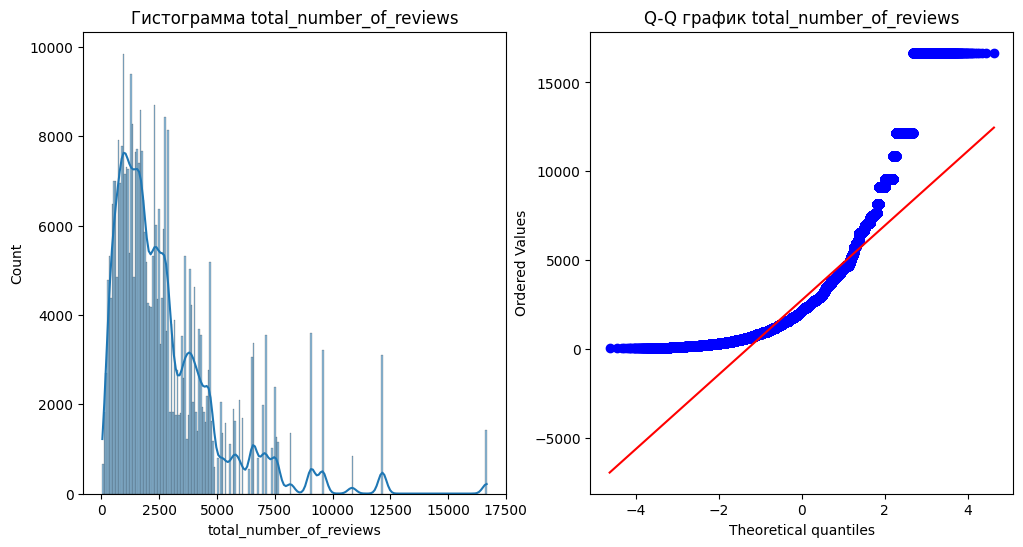

Тест Колмогорова-Смирнова для total_number_of_reviews: Статистика=0.144, p-значение=0.000
Распределение total_number_of_reviews не нормально (отвергаем H0)




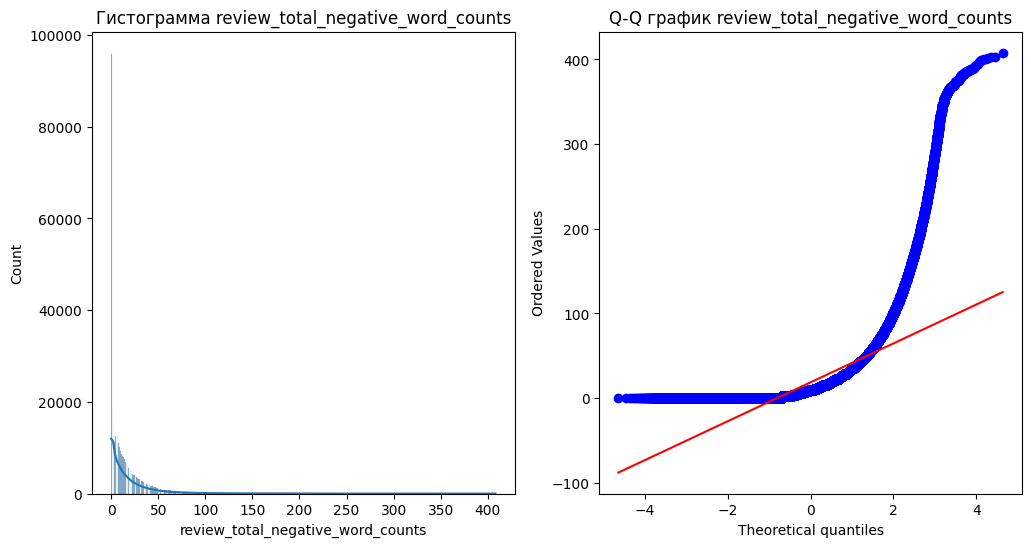

Тест Колмогорова-Смирнова для review_total_negative_word_counts: Статистика=0.266, p-значение=0.000
Распределение review_total_negative_word_counts не нормально (отвергаем H0)




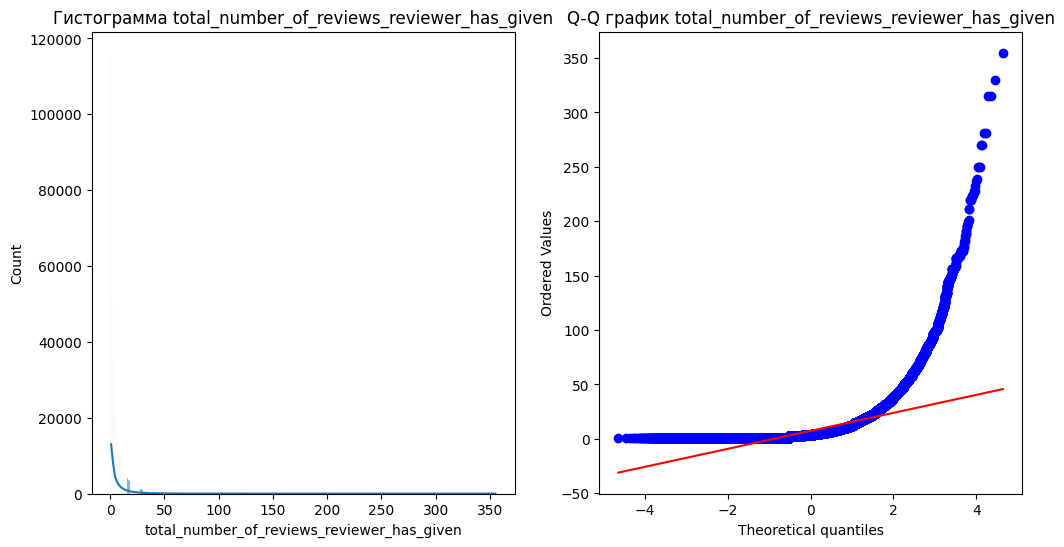

Тест Колмогорова-Смирнова для total_number_of_reviews_reviewer_has_given: Статистика=0.288, p-значение=0.000
Распределение total_number_of_reviews_reviewer_has_given не нормально (отвергаем H0)




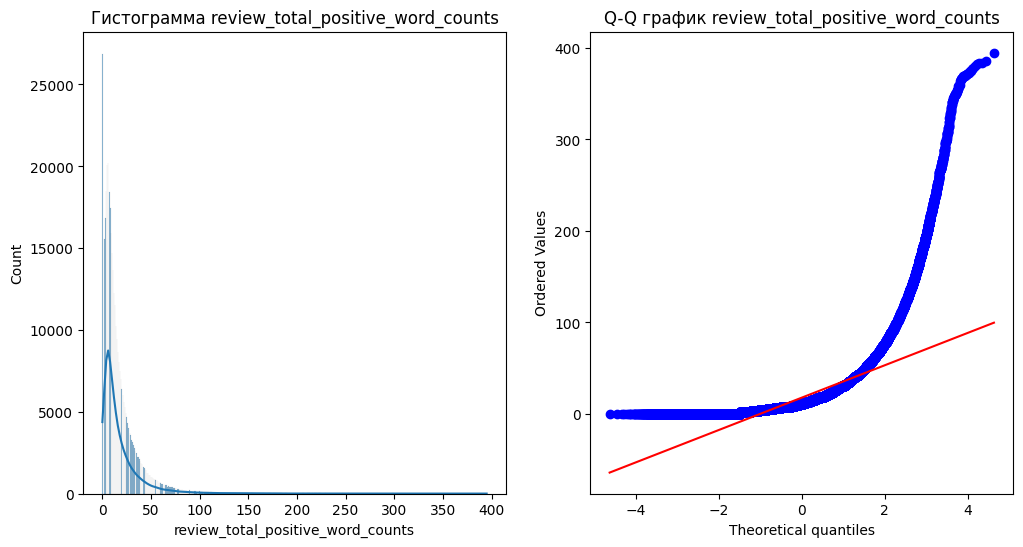

Тест Колмогорова-Смирнова для review_total_positive_word_counts: Статистика=0.207, p-значение=0.000
Распределение review_total_positive_word_counts не нормально (отвергаем H0)




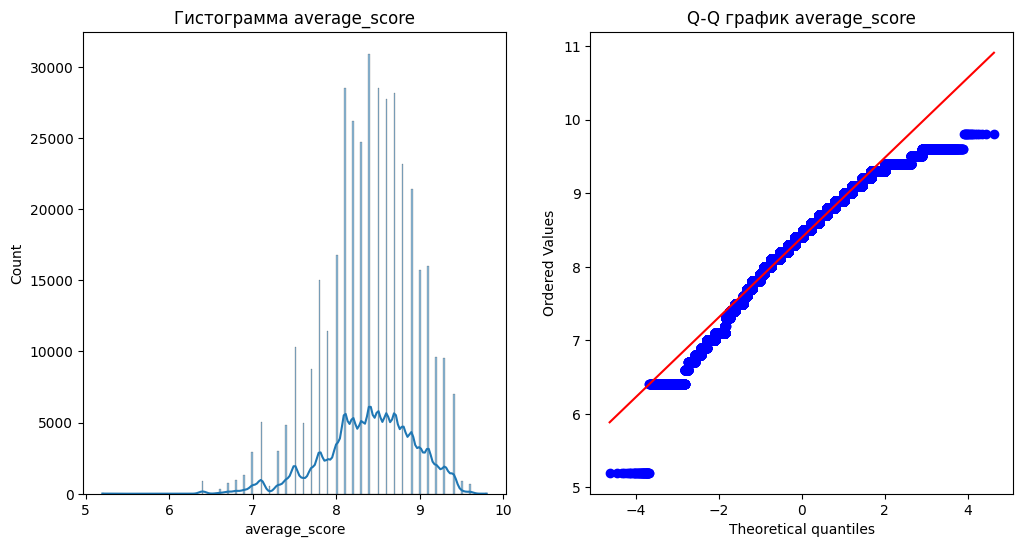

Тест Колмогорова-Смирнова для average_score: Статистика=0.070, p-значение=0.000
Распределение average_score не нормально (отвергаем H0)




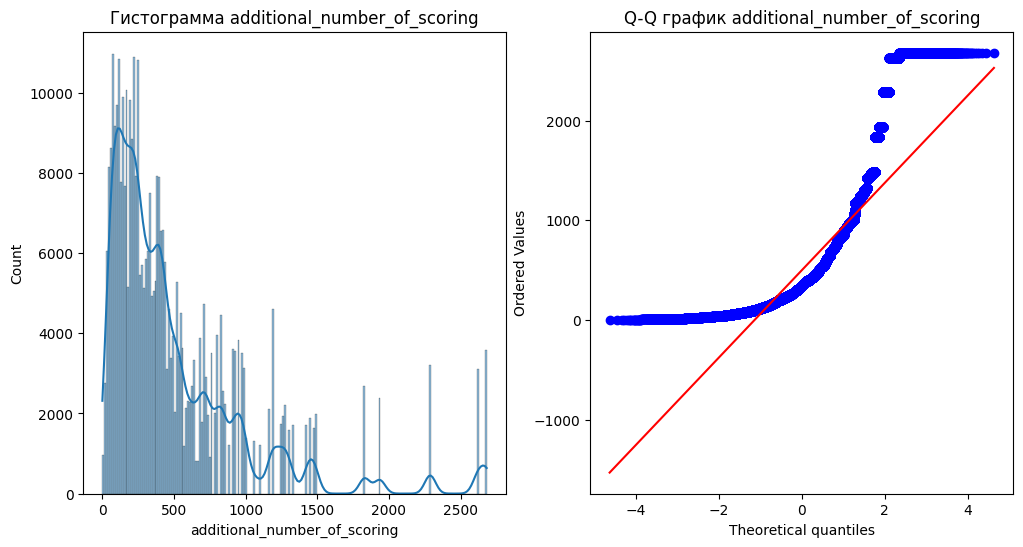

Тест Колмогорова-Смирнова для additional_number_of_scoring: Статистика=0.168, p-значение=0.000
Распределение additional_number_of_scoring не нормально (отвергаем H0)




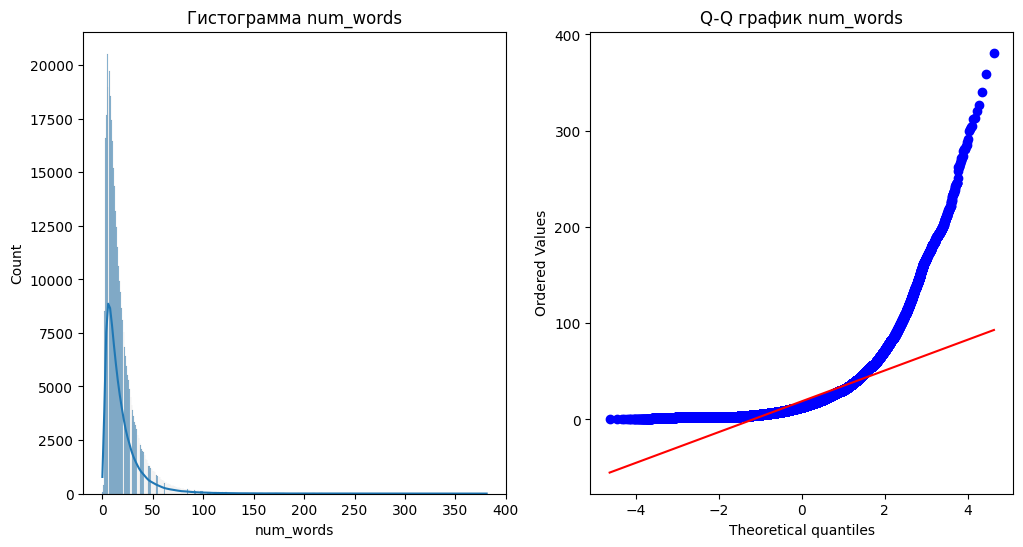

Тест Колмогорова-Смирнова для num_words: Статистика=0.187, p-значение=0.000
Распределение num_words не нормально (отвергаем H0)




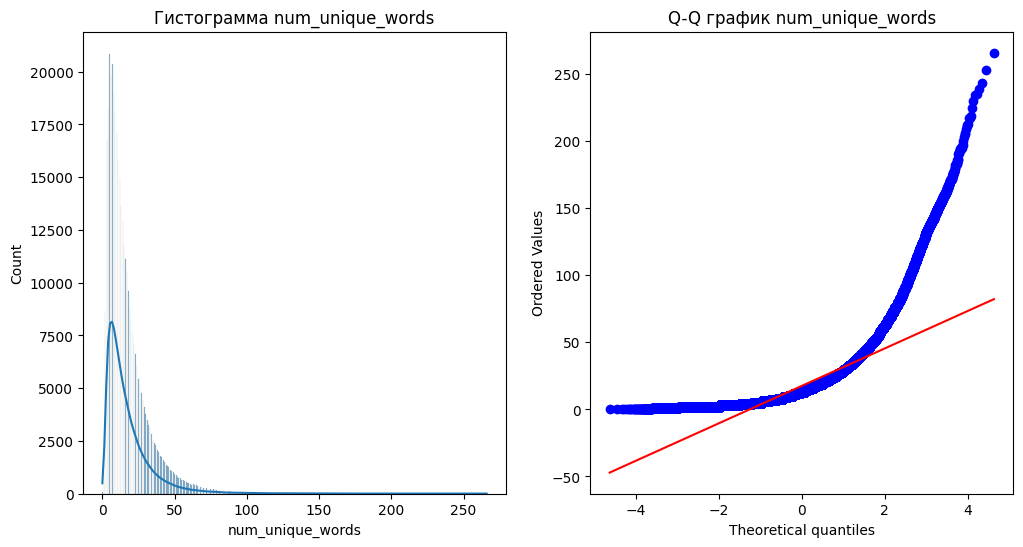

Тест Колмогорова-Смирнова для num_unique_words: Статистика=0.167, p-значение=0.000
Распределение num_unique_words не нормально (отвергаем H0)




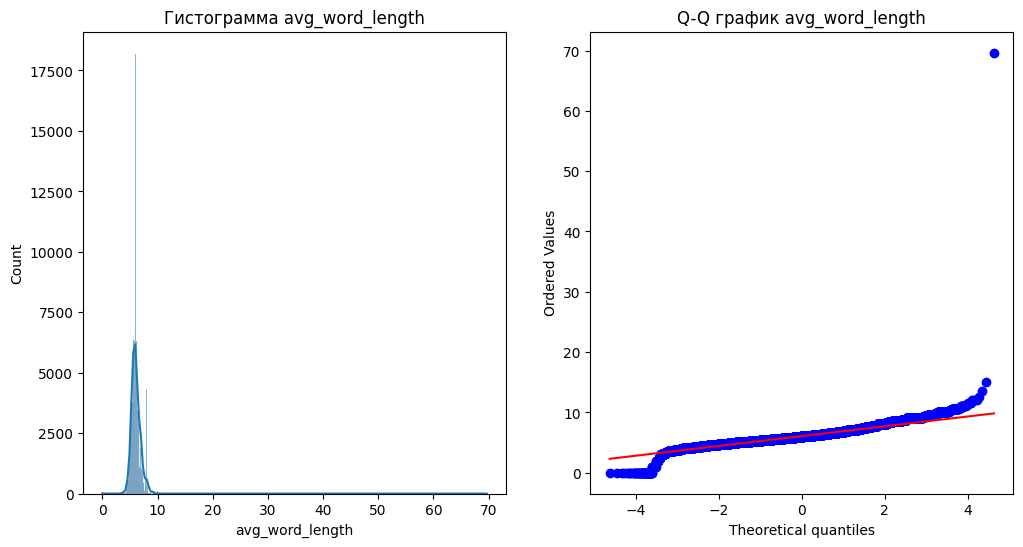

Тест Колмогорова-Смирнова для avg_word_length: Статистика=0.077, p-значение=0.000
Распределение avg_word_length не нормально (отвергаем H0)




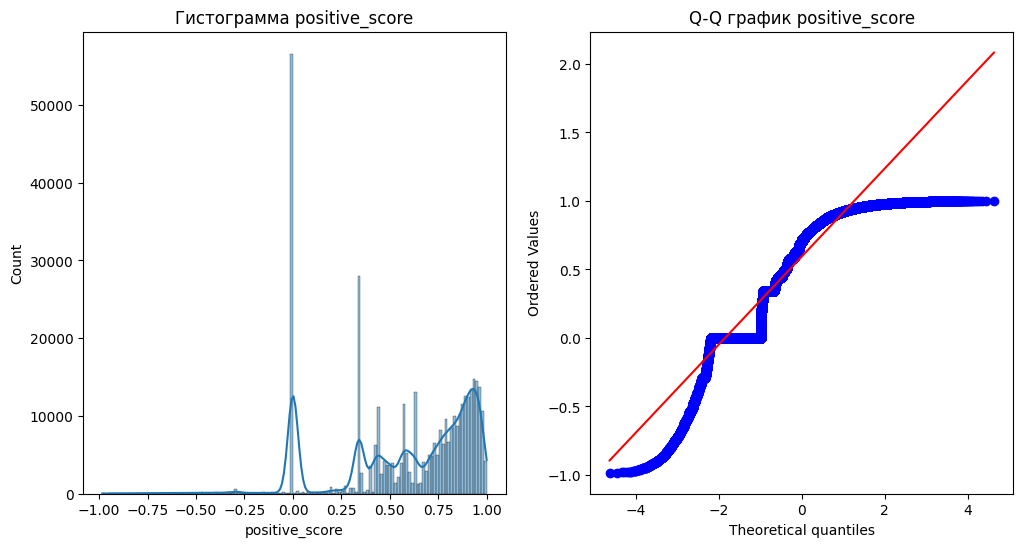

Тест Колмогорова-Смирнова для positive_score: Статистика=0.137, p-значение=0.000
Распределение positive_score не нормально (отвергаем H0)




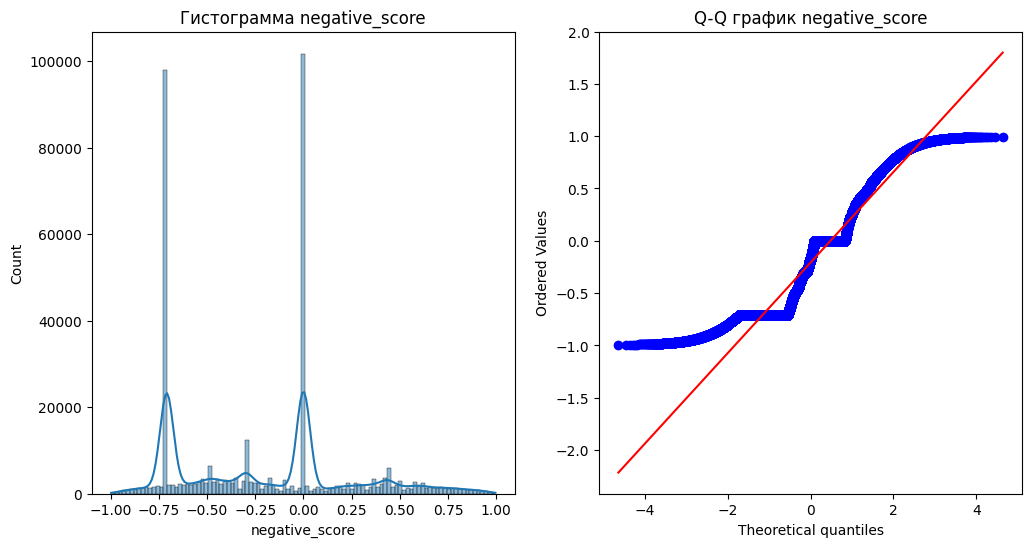

Тест Колмогорова-Смирнова для negative_score: Статистика=0.156, p-значение=0.000
Распределение negative_score не нормально (отвергаем H0)




In [256]:
# Функция для проверки нормальности с использованием теста Колмогорова-Смирнова, т.к. значений более 5000
def check_normality(df, columns):
    for column in columns:
        # Графический метод: гистограмма
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Гистограмма {column}')
        
        # Q-Q график
        plt.subplot(1, 2, 2)
        stats.probplot(df[column], dist="norm", plot=plt)
        plt.title(f'Q-Q график {column}')
        
        plt.show()
        
        # Статистический тест: тест Колмогорова-Смирнова
        stat, p = stats.kstest(df[column], 'norm', args=(df[column].mean(), df[column].std()))
        print(f'Тест Колмогорова-Смирнова для {column}: Статистика={stat:.3f}, p-значение={p:.3f}')
        
        # Интерпретация результата
        alpha = 0.05
        if p > alpha:
            print(f'Распределение {column} нормально (не отвергаем H0)')
        else:
            print(f'Распределение {column} не нормально (отвергаем H0)')
        print('\n')

# Проверяем нормальность для указанных столбцов
check_normality(hotels, scaling_columns)

### Нормализация и стандартизация

Распределение отличается от нормального, есть выбросы - поэтому для нормализации используем методы RobustScaler или PowerTransformer

Для проверки влияния на MAPE проведем также сравнение методов нормализации и сопоставим метрики.

Итоговые метрики MAPE для разных методов нормализации: 
- 0.12533206314154807 - RobustScaler
- 0.12542054975340974 - MinMaxScaler
- 0.12482383153680582 - PowerTransformer

Выбираем в качестве базового - метод нормализации PowerTransformer, как обеспечивающий лучшую точность работы модели при равных условиях

In [257]:
# scaling_columns = ['total_number_of_reviews', 'review_total_negative_word_counts', 
#        'total_number_of_reviews_reviewer_has_given',
#        'review_total_positive_word_counts', 'average_score',  
#        'additional_number_of_scoring',  'num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']

# инициализируем нормализатор RobustScaler
#scaler = preprocessing.RobustScaler()

# инициализируем нормализатор MinMaxScaler
#scaler = preprocessing.MinMaxScaler()

# Применяем RobustScaler только к выбранным столбцам
#hotels[scaling_columns] = scaler.fit_transform(hotels[scaling_columns])


# Проверим нормализацию с помощью PowerTransformer и проверим метрики
# Инициализируем нормализатор PowerTransformer
scaler = preprocessing.PowerTransformer(method='yeo-johnson')  # или method='box-cox' если данные положительные

# Применяем PowerTransformer только к выбранным столбцам
hotels[scaling_columns] = scaler.fit_transform(hotels[scaling_columns])

#print("Параметры преобразования:", scaler.lambdas_)

### Проверяем нормальность для указанных столбцов после шкалирования

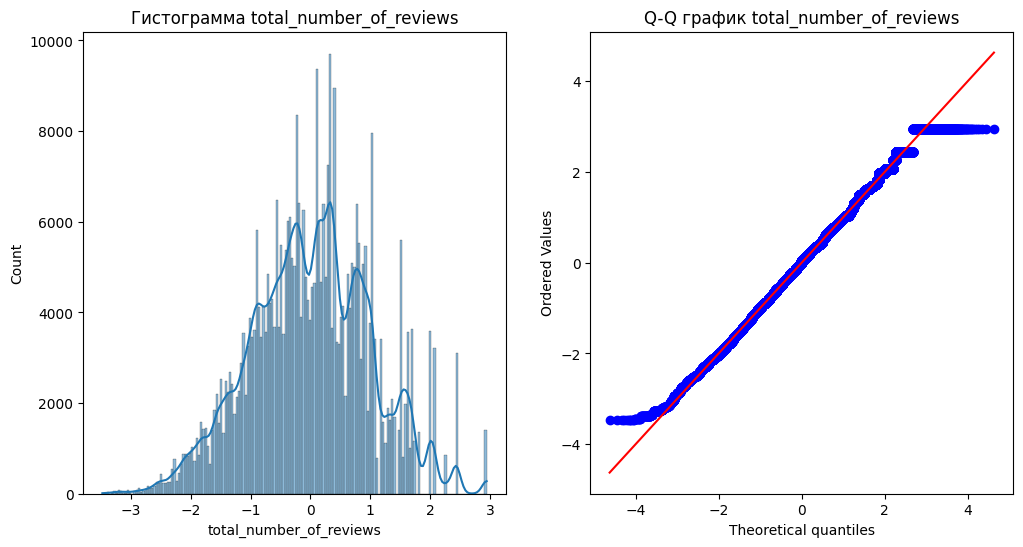

Тест Колмогорова-Смирнова для total_number_of_reviews: Статистика=0.021, p-значение=0.000
Распределение total_number_of_reviews не нормально (отвергаем H0)




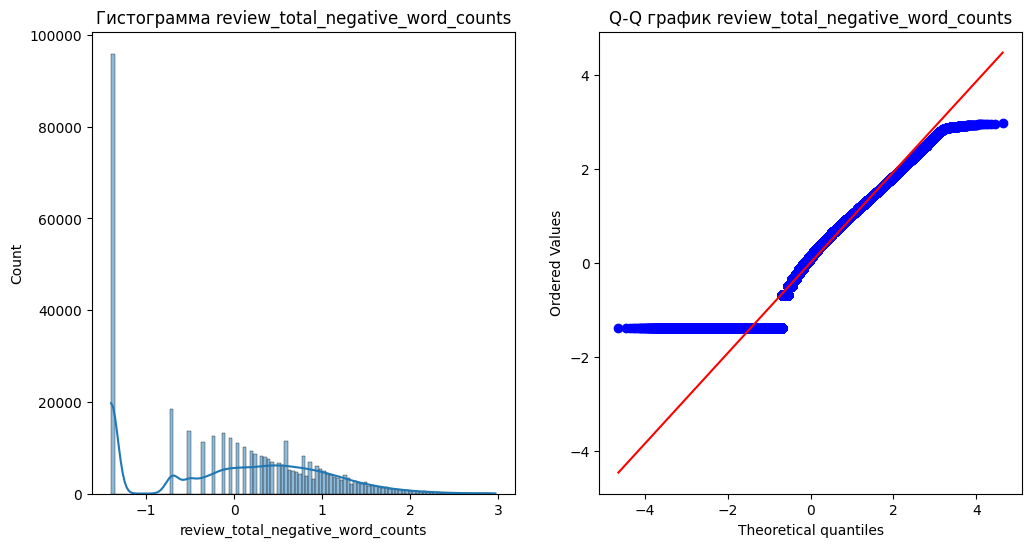

Тест Колмогорова-Смирнова для review_total_negative_word_counts: Статистика=0.167, p-значение=0.000
Распределение review_total_negative_word_counts не нормально (отвергаем H0)




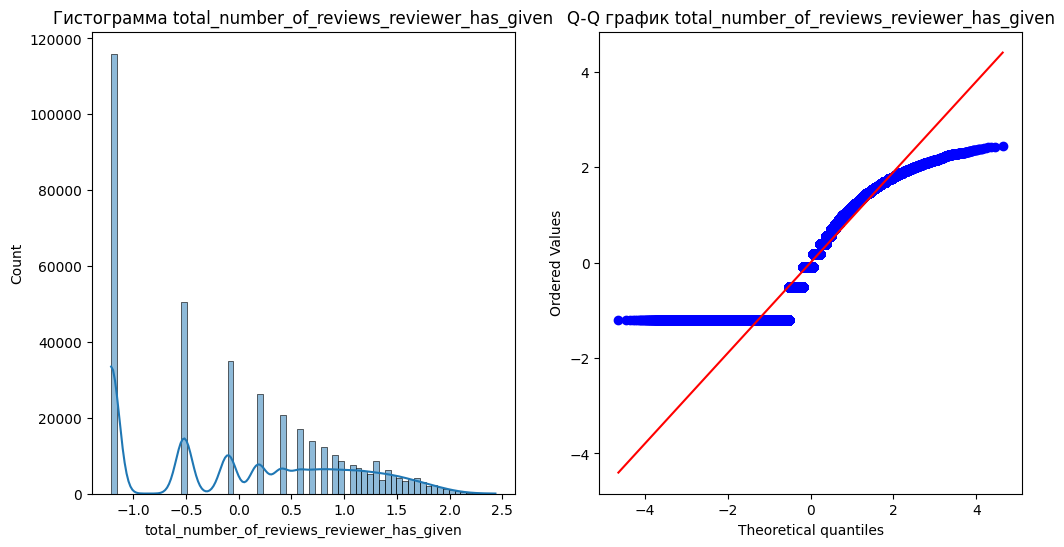

Тест Колмогорова-Смирнова для total_number_of_reviews_reviewer_has_given: Статистика=0.186, p-значение=0.000
Распределение total_number_of_reviews_reviewer_has_given не нормально (отвергаем H0)




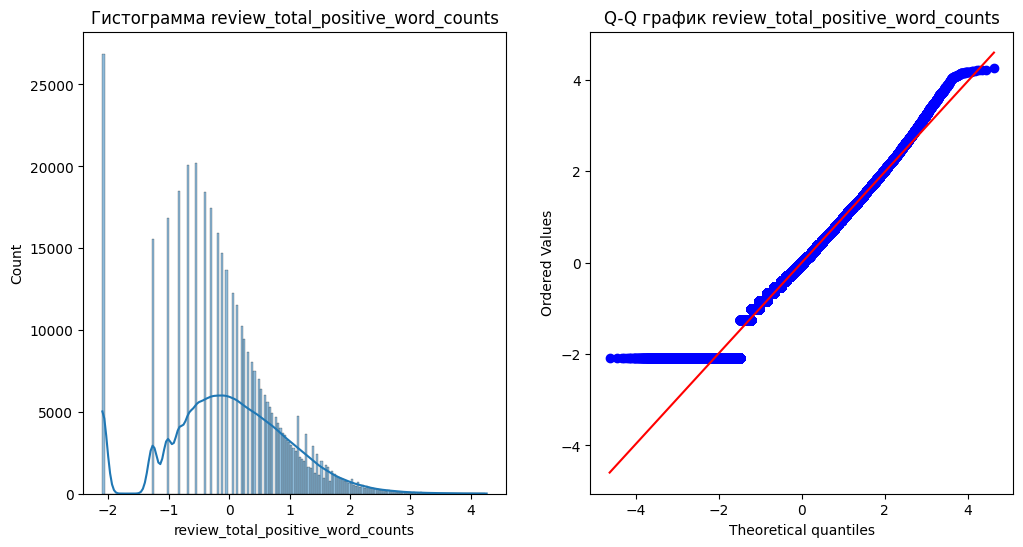

Тест Колмогорова-Смирнова для review_total_positive_word_counts: Статистика=0.051, p-значение=0.000
Распределение review_total_positive_word_counts не нормально (отвергаем H0)




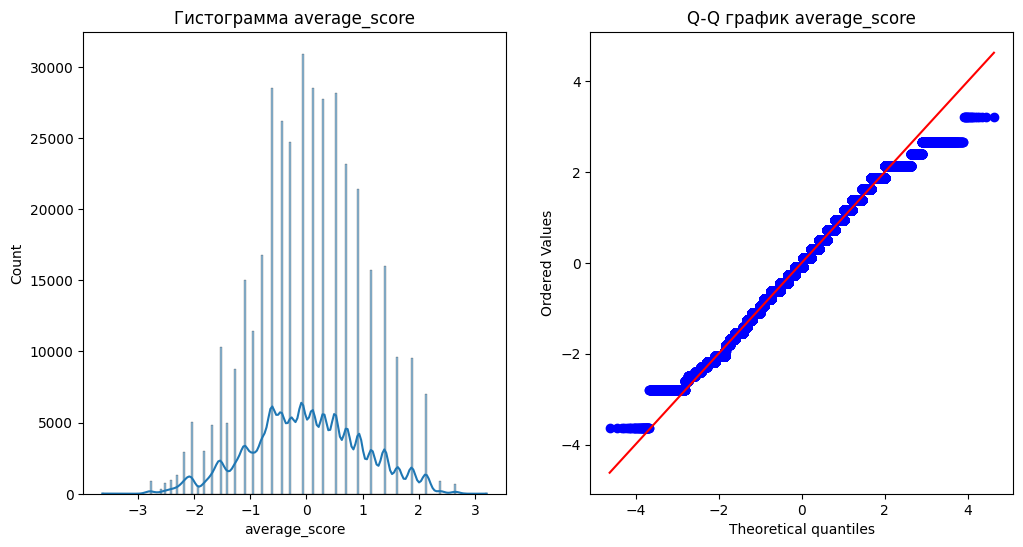

Тест Колмогорова-Смирнова для average_score: Статистика=0.046, p-значение=0.000
Распределение average_score не нормально (отвергаем H0)




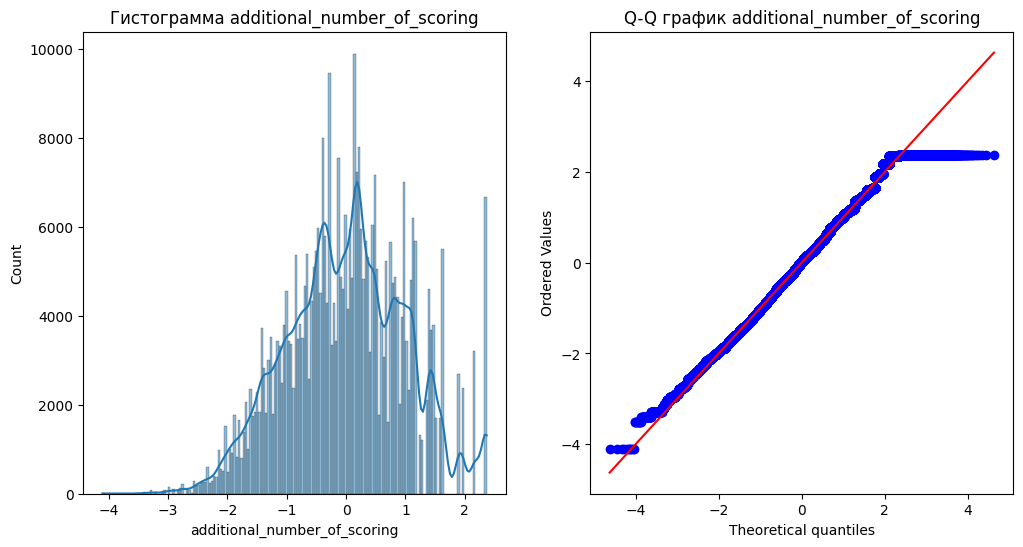

Тест Колмогорова-Смирнова для additional_number_of_scoring: Статистика=0.020, p-значение=0.000
Распределение additional_number_of_scoring не нормально (отвергаем H0)




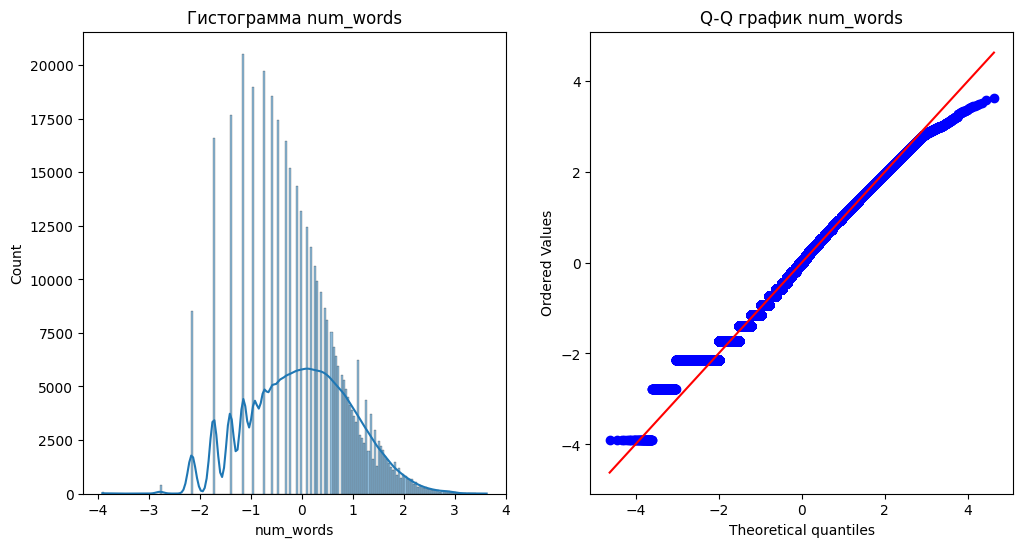

Тест Колмогорова-Смирнова для num_words: Статистика=0.039, p-значение=0.000
Распределение num_words не нормально (отвергаем H0)




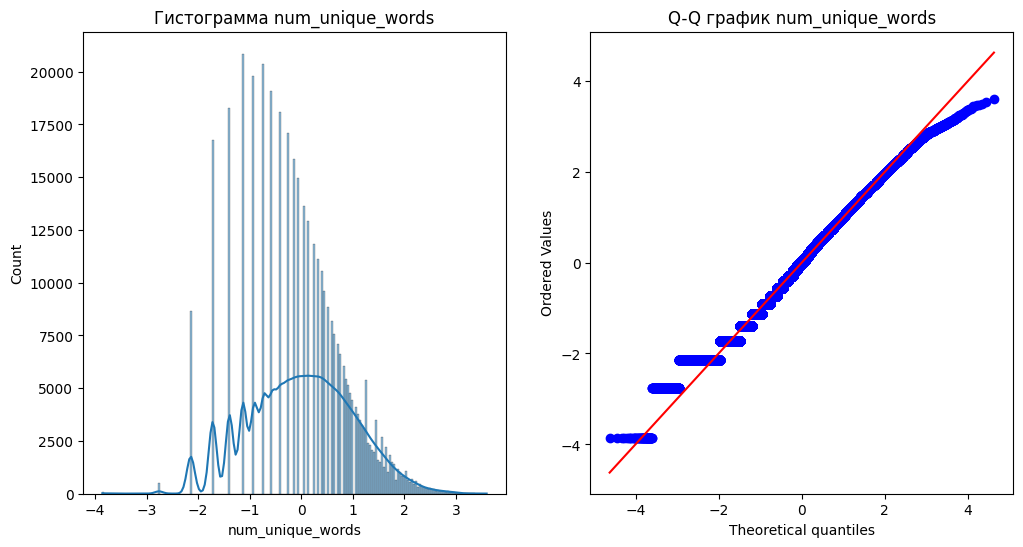

Тест Колмогорова-Смирнова для num_unique_words: Статистика=0.039, p-значение=0.000
Распределение num_unique_words не нормально (отвергаем H0)




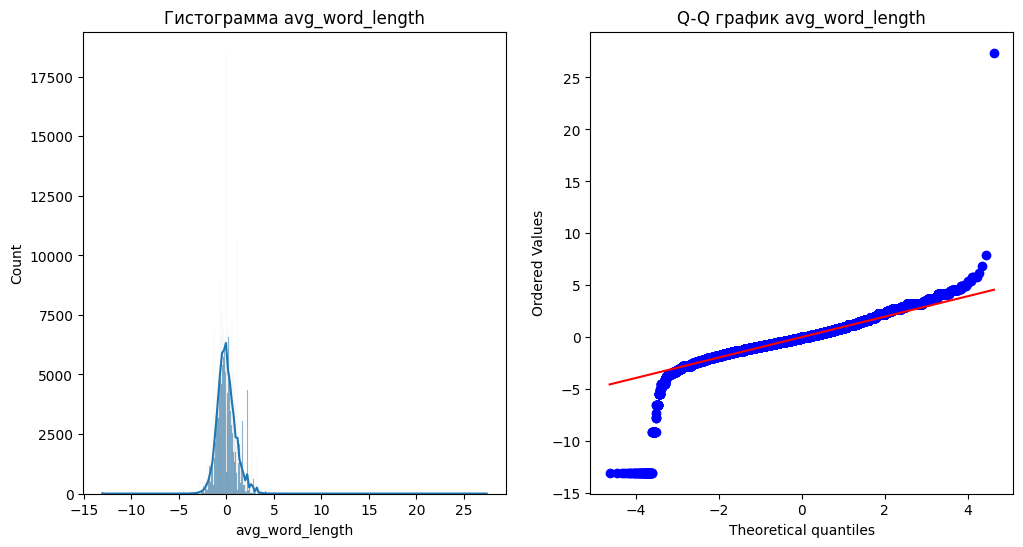

Тест Колмогорова-Смирнова для avg_word_length: Статистика=0.060, p-значение=0.000
Распределение avg_word_length не нормально (отвергаем H0)




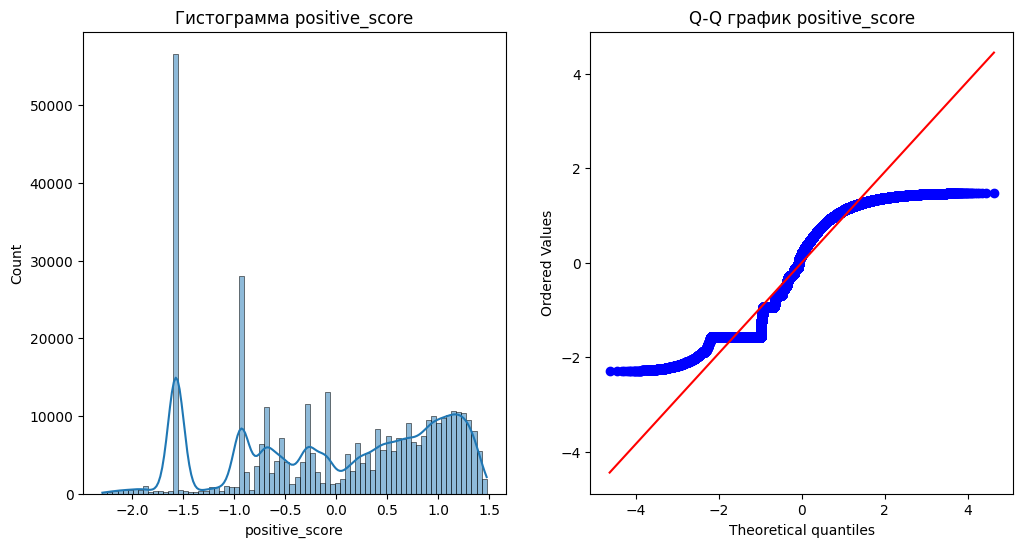

Тест Колмогорова-Смирнова для positive_score: Статистика=0.104, p-значение=0.000
Распределение positive_score не нормально (отвергаем H0)




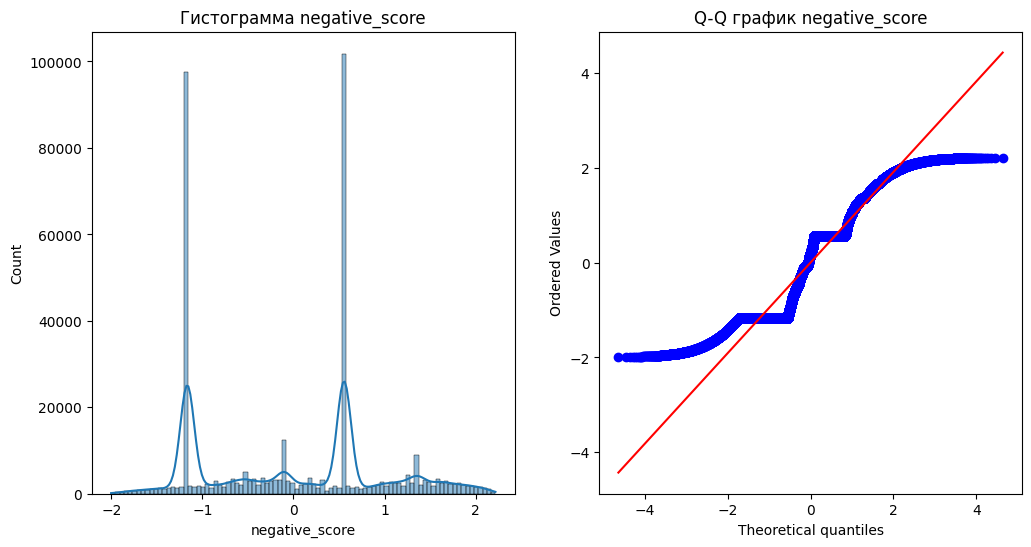

Тест Колмогорова-Смирнова для negative_score: Статистика=0.177, p-значение=0.000
Распределение negative_score не нормально (отвергаем H0)




In [258]:
# Проверяем нормальность для указанных столбцов после нормализации
check_normality(hotels, scaling_columns)

In [259]:
hotels[scaling_columns].describe()

total_number_of_reviews  review_total_negative_word_counts  \
count             3.868030e+05                       3.868030e+05   
mean              2.140144e-15                      -2.110670e-16   
std               1.000001e+00                       1.000001e+00   
min              -3.475677e+00                      -1.395592e+00   
25%              -6.756628e-01                      -6.966168e-01   
50%               2.278666e-02                       1.164442e-01   
75%               6.834172e-01                       7.402988e-01   
max               2.943461e+00                       2.966459e+00   

       total_number_of_reviews_reviewer_has_given  \
count                                3.868030e+05   
mean                                -8.113865e-17   
std                                  1.000001e+00   
min                                 -1.208557e+00   
25%                                 -1.208557e+00   
50%                                 -1.000775e-01   
75%                                  8.129845e-01   
max                                  2.435244e+00   

       review_total_positive_word_counts  average_score  \
count                       3.868030e+05   3.868030e+05   
mean                       -2.424791e-18  -3.343135e-16   
std                         1.000001e+00   1.000001e+00   
min                        -2.095818e+00  -3.637582e+00   
25%                        -6.724091e-01  -6.220018e-01   
50%                        -2.784560e-02  -8.470762e-02   
75%                         6.315573e-01   7.179227e-01   
max                         4.260035e+00   3.210961e+00   

       additional_number_of_scoring     num_words  num_unique_words  \
count                  3.868030e+05  3.868030e+05      3.868030e+05   
mean                   4.018907e-16  1.180731e-15      2.556639e-16   
std                    1.000001e+00  1.000001e+00      1.000001e+00   
min                   -4.103889e+00 -3.906556e+00     -3.856623e+00   
25%                   -6.808917e-01 -7.452135e-01     -7.244855e-01   
50%                    1.582889e-02 -1.909226e-03      4.045191e-02   
75%                    7.135073e-01  7.251521e-01      6.933987e-01   
max                    2.368741e+00  3.626852e+00      3.593272e+00   

       avg_word_length  positive_score  negative_score  
count     3.868030e+05    3.868030e+05    3.868030e+05  
mean     -4.144372e-16   -3.261344e-16    3.207337e-17  
std       1.000001e+00    1.000001e+00    1.000001e+00  
min      -1.304661e+01   -2.295338e+00   -2.002009e+00  
25%      -6.497400e-01   -9.022382e-01   -1.166232e+00  
50%      -6.938274e-02    1.956948e-01    1.722739e-01  
75%       5.770429e-01    9.187702e-01    5.554391e-01  
max       2.739285e+01    1.473454e+00    2.217304e+00

## Отбор признаков по критерию мультиколлинеарности

Проведём корреляционный анализ датасета и используем для этого тепловую карту корреляций признаков.
Используем Plotly, чтобы удобнее было визуализировать тепловую карту матрицы корреляции с большим количеством признаков.

In [260]:
# Вычисляем корреляционную матрицу
numerical_hotels = hotels.select_dtypes(include=['number'])

# Вычисляем матрицу корреляции
correlation_matrix = numerical_hotels.corr()

# Создаем тепловую карту, используя Plotly
fig = px.imshow(correlation_matrix, 
                text_auto=True, 
                color_continuous_scale='Viridis', 
                title='Correlation Heatmap')

# Отображаем график
fig.show()

Вывод пар с высокой корреляцией (мультиколлинеарностью)

In [261]:
# Вычисляем матрицу корреляции
#correlation_matrix = hotels.corr()

# устанавливаем пороговое значение корреляции для мультиколлинеарности
# limit_multicolinear_corr = 0.75

# Убираем дубликаты и оставляем только верхний треугольник
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
filtered_corr = correlation_matrix.where(mask)

# Извлекаем пары с коэффициентом корреляции больше 0.75 (LIMIT_MULTICOLINEAR_CORR)
high_corr_pairs = filtered_corr.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation Coefficient']

# Фильтруем по значению корреляции
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation Coefficient'] > LIMIT_MULTICOLINEAR_CORR]

# Проверяем результат
display(high_corr_pairs)

Variable 1               Variable 2  \
2     additional_number_of_scoring  total_number_of_reviews   
406                            lat          hotel_country_3   
1316                     num_words         num_unique_words   

      Correlation Coefficient  
2                    0.875821  
406                  0.806349  
1316                 0.997460

In [262]:
# Функция для выбора признаков для исключения по признаку мультиколлинеарности
def select_features_to_exclude(high_corr_pairs):
    # Инициализируем множества для отслеживания признаков для исключения для обеих стратегий
    features_to_exclude_var1 = set()
    features_to_exclude_var2 = set()
    
    # Проходим по парам с высокой корреляцией для стратегии var1
    for index, row in high_corr_pairs.iterrows():
        var1 = row['Variable 1']
        var2 = row['Variable 2']
        
        # Если ни один из признаков не находится в множестве исключений, добавляем var1
        if var1 not in features_to_exclude_var1 and var2 not in features_to_exclude_var1:
            features_to_exclude_var1.add(var1)
    
    # Проходим по парам с высокой корреляцией для стратегии var2
    for index, row in high_corr_pairs.iterrows():
        var1 = row['Variable 1']
        var2 = row['Variable 2']
        
        # Если ни один из признаков не находится в множестве исключений, добавляем var2
        if var1 not in features_to_exclude_var2 and var2 not in features_to_exclude_var2:
            features_to_exclude_var2.add(var2)
    
    # Сравниваем длины обоих множеств и возвращаем меньшее или оба, если они равны
    if len(features_to_exclude_var1) < len(features_to_exclude_var2):
        return [list(features_to_exclude_var1), list(features_to_exclude_var2)]
    elif len(features_to_exclude_var1) > len(features_to_exclude_var2):
        return [list(features_to_exclude_var2), list(features_to_exclude_var1)]
    else:
        return [list(features_to_exclude_var1), list(features_to_exclude_var2)]

# Формируем список списков потенциальных признаков по критерию мультиколлинеарности
features_to_exclude = select_features_to_exclude(high_corr_pairs)
display("Потенциальные признаки для исключения по критерию мультиколлинеарности (один из списков):", features_to_exclude)

'Потенциальные признаки для исключения по критерию мультиколлинеарности (один из списков):'

[['num_words', 'additional_number_of_scoring', 'lat'],
 ['num_unique_words', 'hotel_country_3', 'total_number_of_reviews']]

### Определяем признаки с сильной корреляционной связью (мультиколлинеарностью)

In [263]:
# требуется проверка на итоговый результат MAPE

#multicolinear_cols = ['additional_number_of_scoring', 'num_words', 'num_unique_words']
#multicolinear_cols = ['additional_number_of_scoring', 'num_words', 'num_unique_words', 'lat']

# при нормализваии PowerTransformer уменьшилось количество признаковв с мультиколлинеарностью

multicolinear_cols = features_to_exclude[0]

# можно изменить multicolinear_cols вручную
#multicolinear_cols = ['additional_number_of_scoring', 'lat', 'num_words']

multicolinear_cols


['num_words', 'additional_number_of_scoring', 'lat']

In [264]:
# Проверяем наличие пропусков в датасете hotel
missing_values = hotels.isna().sum()
    
# Проверяем, есть ли пропуски
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel: ')
    display(missing_values[missing_values > 0])  # Показываем только те столбцы, где есть пропуски
else:
    display('Пропусков NaN в датасете hotel нет')

'Пропусков NaN в датасете hotel нет'

## Отбор признаков по значимости


Оцениваем значимость каждого признака для целевой переменной — рейтинга отеля reviewer_score.

Для оценки значимости категориальных признаков используем тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [265]:
# Выбираем все числовые столбцы
numeric_cols = hotels.select_dtypes(include=['number']).columns

# Исключаем бинарные столбцы (где значения только 0 и 1)
# непрерывные числовые признаки
num_cols = non_binary_numeric_cols = [col for col in numeric_cols if not hotels[col].isin([0, 1]).all()]

# Выбираем бинарные столбцы (где значения только 0 и 1)
# категориальные, бинарные признаки
cat_cols = binary_numeric_cols = [col for col in numeric_cols if hotels[col].isin([0, 1]).all()]

# num_cols = non_binary_numeric_cols
# cat_cols = binary_numeric_cols

display(f'Непрерывные числовые признаки {num_cols}')
display(f'Бинарные признаки {cat_cols}')

"Непрерывные числовые признаки ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'days_since_review', 'lat', 'lng', 'stayed_nights', 'review_year', 'review_month', 'review_day', 'season', 'day_of_week', 'num_words', 'num_unique_words', 'avg_word_length', 'positive_score', 'negative_score']"

"Бинарные признаки ['leisure_trip', 'business_trip', 'mobile_booking', 'solo_traveler', 'couple', 'group', 'family_with_young_children', 'family_with_older_children', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_country_0', 'hotel_country_1', 'hotel_country_2', 'hotel_country_3', 'room_type_filled_0', 'room_type_filled_1', 'room_type_filled_2', 'room_type_filled_3', 'room_type_filled_4', 'room_type_filled_5', 'room_type_filled_6', 'room_type_filled_7', 'room_type_filled_8', 'room_type_filled_9', 'room_type_filled_10']"

In [266]:
# # непрерывные числовые признаки
# num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
#        'total_number_of_reviews_reviewer_has_given',
#        'review_total_positive_word_counts', 'average_score', 'days_since_review', 'stayed_nights',
#        'additional_number_of_scoring', 'num_words', 'num_unique_words', 'avg_word_length', 
#        'positive_score', 'negative_score']

# # категориальные признаки
# cat_cols = [ 'lat',  'season', 'day_of_week', 'leisure_trip', 'business_trip',
#        'mobile_booking', 'solo_traveler', 'couple', 'group', 'review_day', 'review_month', 'review_year',
#        'family_with_young_children', 'family_with_older_children',  
#        'reviewer_nationality_0', 'reviewer_nationality_1',
#        'reviewer_nationality_2', 'reviewer_nationality_3',
#        'reviewer_nationality_4', 'reviewer_nationality_5',
#        'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_country_0',
#        'hotel_country_1', 'hotel_country_2', 'hotel_country_3']

#Удаляем ранее удаленние признаки с сильной корреляционной связью (мультиколлинеарностью)
filtered_num_cols = [col for col in num_cols if col not in multicolinear_cols]
filtered_cat_cols = [col for col in cat_cols if col not in multicolinear_cols]


Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке ***sklearn.feature_selection.chi2***. 

Метод возвращает массив значений хи-квадрат и p-value для каждого признака.

Используем только значения хи-квадрат и выведем их на графике:

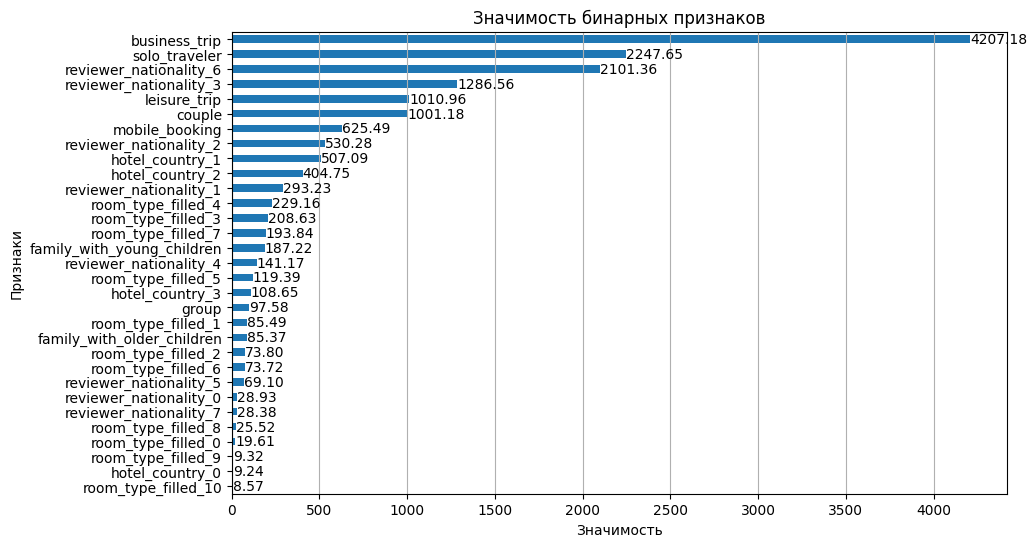

In [267]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
#X = hotels[cat_cols] 

y = hotels['reviewer_score'].round(2).astype('int')
#y = y.round(2).astype('int')

# Исключаем 'reviewer_score' из списка
filtered_cat_cols_excluded = [col for col in filtered_cat_cols if col != 'reviewer_score']

imp_cat = pd.Series(chi2(X[filtered_cat_cols_excluded], y)[0], index=filtered_cat_cols_excluded)
imp_cat.sort_values(inplace = True)
#imp_cat.plot(kind = 'barh')

plt.figure(figsize=(10, 6))
ax = imp_cat.plot(kind='barh')

# Добавляем подписи к графику
for i in ax.patches:
    ax.text(i.get_width() + 0.01, i.get_y() + i.get_height()/2, 
            f'{i.get_width():.2f}', 
            va='center')  # Выравнивание по вертикали

# Настраиваем график
plt.title('Значимость бинарных признаков')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.grid(axis='x')

# Показываем график
plt.show()


Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

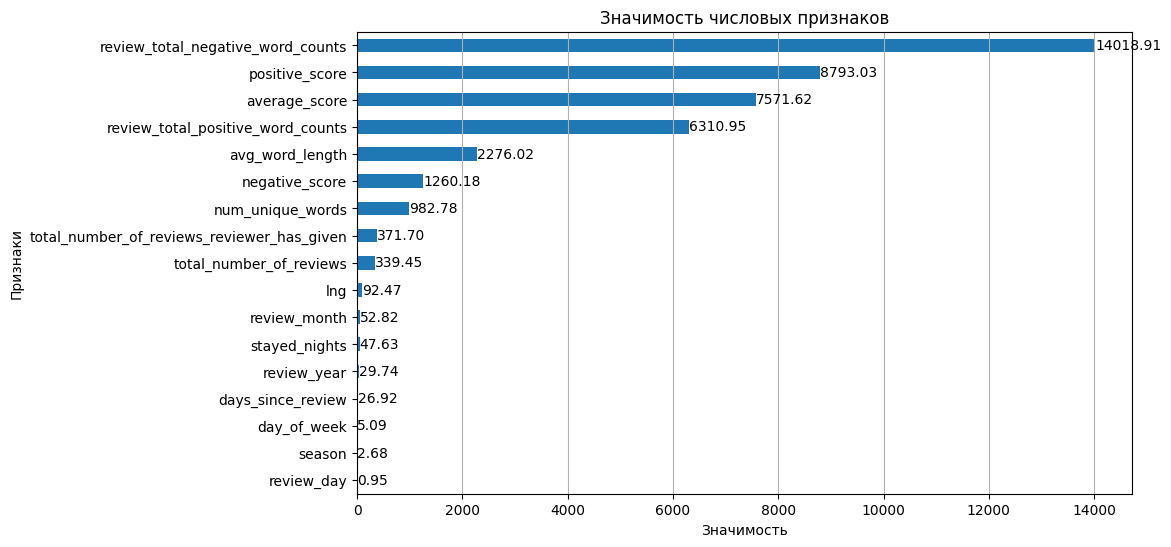

In [268]:
# Исключаем 'reviewer_score' из списка
filtered_num_cols_excluded = [col for col in filtered_num_cols if col != 'reviewer_score']


imp_num = pd.Series(f_classif(X[filtered_num_cols_excluded], y)[0], index = filtered_num_cols_excluded)
imp_num.sort_values(inplace = True)
#imp_num.plot(kind = 'barh')
# Строим график
plt.figure(figsize=(10, 6))
ax = imp_num.plot(kind='barh')

# Добавляем подписи к графику
for i in ax.patches:
    ax.text(i.get_width() + 0.01, i.get_y() + i.get_height()/2, 
            f'{i.get_width():.2f}', 
            va='center')  # Выравнивание по вертикали

# Настраиваем график
plt.title('Значимость числовых признаков')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.grid(axis='x')

# Показываем график
plt.show()


In [269]:
# Устанавливаем порог значимости на уровне 25-го квантиля
threshold_cat = imp_cat.quantile(THRESHOLD_QUANTILE)

# Выбираем признаки с низкой значимостью
low_importance_features_cat = imp_cat[imp_cat < threshold_cat]

# Проверяем результат
display("Кандидаты в Бинарные признаки с низкой значимостью:")
display(low_importance_features_cat)

# Исключаем признаки, полученные бинарным кодированием
low_importance_features_cat_list = low_importance_features_cat[~low_importance_features_cat.index.str.contains(r'_\d+$')].index.tolist()

# Проверяем результат
display("Список кандидатов в Бинарные признаки с низкой значимостью:")
display(low_importance_features_cat_list)


# Проверяем случай, когда бинарные признаки с одним префиксом - все ли являются признаками с низкой значимостью
low_importance_cat_bin_list = low_importance_features_cat[low_importance_features_cat.index.str.contains(r'_\d+$')].index.tolist()
imp_cat_bin_list = imp_cat[imp_cat.index.str.contains(r'_\d+$')].index.tolist()


# Функция для получения префиксов названий биинарных признаков
def get_prefixes(column_list):
    prefixes = {}
    for col in column_list:
        prefix = col.rsplit('_', 1)[0]  # Получаем префикс
        if prefix not in prefixes:
            prefixes[prefix] = 0
        prefixes[prefix] += 1
    return prefixes

# Получаем префиксы и их количество
low_importance_prefixes = get_prefixes(low_importance_cat_bin_list)
imp_prefixes = get_prefixes(imp_cat_bin_list)

# Сравниваем количество колонок с одинаковыми префиксами
comparison_results = {}

for prefix in low_importance_prefixes:
    low_count = low_importance_prefixes[prefix]
    imp_count = imp_prefixes.get(prefix, 0)  # Получаем количество из imp_cat, если префикс отсутствует
    comparison_results[prefix] = {'low_importance_count': low_count, 'imp_count': imp_count}
    # Если количество совпадает, добавляем все колонки с этим префиксом в список
    if low_count == imp_count:
        # Добавляем все колонки с данным префиксом из low_importance_all_bin_list
        low_importance_features_cat_list.extend([col for col in low_importance_cat_bin_list if col.startswith(prefix)])

# Проверяем результат
print("Сравнение количества колонок с одинаковыми префиксами:")
for prefix, counts in comparison_results.items():
    print(f"Префикс: {prefix}, Низкая значимость: {counts['low_importance_count']}, Всего: {counts['imp_count']}")

display("Полный список кандидатов в Бинарные признаки с низкой значимостью:")
display(low_importance_features_cat_list)


'Кандидаты в Бинарные признаки с низкой значимостью:'

room_type_filled_10        8.573541
hotel_country_0            9.241552
room_type_filled_9         9.322618
room_type_filled_0        19.605354
room_type_filled_8        25.518257
reviewer_nationality_7    28.383142
reviewer_nationality_0    28.930543
reviewer_nationality_5    69.104859
room_type_filled_6        73.716790
dtype: float64

'Список кандидатов в Бинарные признаки с низкой значимостью:'

[]

Сравнение количества колонок с одинаковыми префиксами:
Префикс: room_type_filled, Низкая значимость: 5, Всего: 11
Префикс: hotel_country, Низкая значимость: 1, Всего: 4
Префикс: reviewer_nationality, Низкая значимость: 3, Всего: 8


'Полный список кандидатов в Бинарные признаки с низкой значимостью:'

[]

In [270]:
# Бинарные признаки с низкой значимостью
insignificant_cols_cat = low_importance_features_cat_list 
#insignificant_cols_cat = ['review_year', 'season', 'review_day']

In [271]:
# Устанавливаем порог значимости на уровне 25-го квантиля
threshold_num = imp_num.quantile(THRESHOLD_QUANTILE)

# Выбираем признаки с низкой значимостью
low_importance_features_num = imp_num[imp_num < threshold_num]

# Проверяем результат
display("Кандидаты в Числовые признаки с низкой значимостью:")
display(low_importance_features_num)

# Исключаем признаки, полученные бинарным кодированием
low_importance_features_num_list = low_importance_features_num[~low_importance_features_num.index.str.contains(r'_\d+$')].index.tolist()

# Проверяем результат
display("Список кандидатов в Числовые признаки с низкой значимостью:")
display(low_importance_features_num_list)

'Кандидаты в Числовые признаки с низкой значимостью:'

review_day            0.954821
season                2.682815
day_of_week           5.086048
days_since_review    26.918686
review_year          29.735462
dtype: float64

'Список кандидатов в Числовые признаки с низкой значимостью:'

['review_day', 'season', 'day_of_week', 'days_since_review', 'review_year']

In [272]:
# числовые признаки с низкой значимостью
insignificant_cols_num = low_importance_features_num_list 
#insignificant_cols_num = ['days_since_review', 'stayed_nights', 'total_number_of_reviews']

Для ДОПОЛНИТЕЛЬНОЙ оценки значимости ВСЕХ переменных дополнительно будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

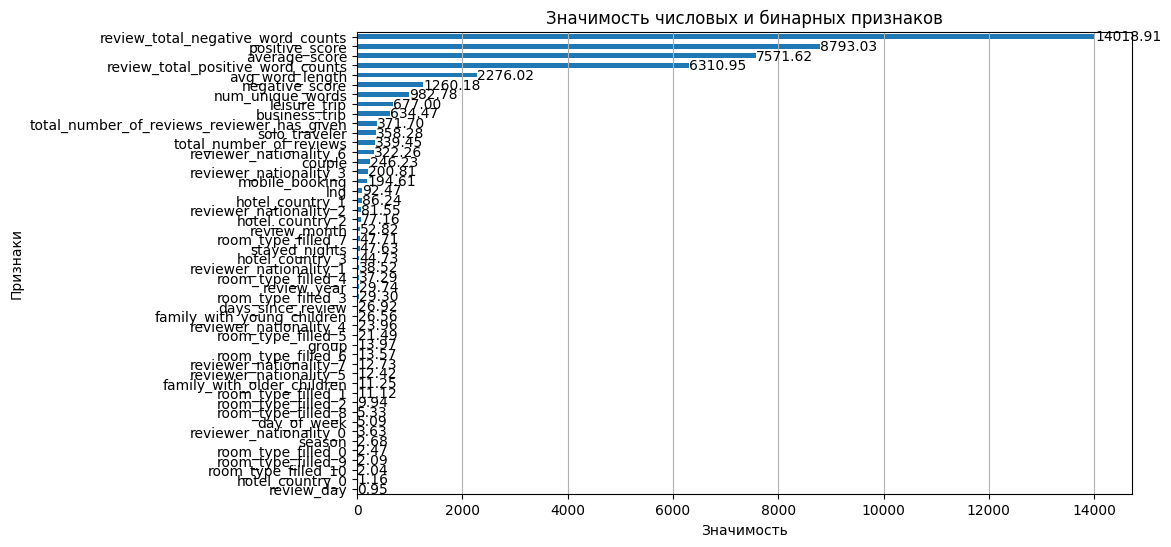

In [273]:
filtered_all_cols = filtered_cat_cols + filtered_num_cols

# Исключаем 'reviewer_score' из списка
filtered_all_cols_excluded = [col for col in filtered_all_cols if col != 'reviewer_score']

imp_all = pd.Series(f_classif(X[filtered_all_cols_excluded], y)[0], index = filtered_all_cols_excluded)
imp_all.sort_values(inplace = True)
#imp_all.plot(kind = 'barh')
# Строим график
plt.figure(figsize=(10, 6))
ax = imp_all.plot(kind='barh')

# Добавляем подписи к графику
for i in ax.patches:
    ax.text(i.get_width() + 0.01, i.get_y() + i.get_height()/2, 
            f'{i.get_width():.2f}', 
            va='center')  # Выравнивание по вертикали

# Настраиваем график
plt.title('Значимость числовых и бинарных признаков')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.grid(axis='x')

# Показываем график
plt.show()

In [274]:
# Устанавливаем порог значимости на уровне 25-го квантиля
threshold_all = imp_all.quantile(THRESHOLD_QUANTILE)

# Выбираем признаки с низкой значимостью
low_importance_features_all = imp_all[imp_all < threshold_all]

# Проверяем результат
display("Кандидаты в Числовые и бинарные признаки с низкой значимостью:")
display(low_importance_features_all)

# Исключаем признаки, полученные бинарным кодированием
low_importance_features_all_list = low_importance_features_all[~low_importance_features_all.index.str.contains(r'_\d+$')].index.tolist()

# Проверяем результат
display("Список кандидатов в Числовые и бинарные признаки с низкой значимостью:")
display(low_importance_features_all_list)


# Проверяем случай, когда бинарные признаки с одним префиксом - ВСЕ являются признаками с низкой значимостью
low_importance_all_bin_list = low_importance_features_all[low_importance_features_all.index.str.contains(r'_\d+$')].index.tolist()
imp_all_bin_list = imp_all[imp_all.index.str.contains(r'_\d+$')].index.tolist()


# Функция для получения префиксов
def get_prefixes(column_list):
    prefixes = {}
    for col in column_list:
        prefix = col.rsplit('_', 1)[0]  # Получаем префикс
        if prefix not in prefixes:
            prefixes[prefix] = 0
        prefixes[prefix] += 1
    return prefixes


# Получаем префиксы и их количество
low_importance_prefixes = get_prefixes(low_importance_all_bin_list)
imp_prefixes = get_prefixes(imp_all_bin_list)

# Сравниваем количество колонок с одинаковыми префиксами
comparison_results = {}

for prefix in low_importance_prefixes:
    low_count = low_importance_prefixes[prefix]
    imp_count = imp_prefixes.get(prefix, 0)  # Получаем количество из imp_all, если префикс отсутствует
    comparison_results[prefix] = {'low_importance_count': low_count, 'imp_count': imp_count}
    # Если количество совпадает, добавляем все колонки с этим префиксом в список
    if low_count == imp_count:
        # Добавляем все колонки с данным префиксом из low_importance_all_bin_list
        low_importance_features_all_list.extend([col for col in low_importance_all_bin_list if col.startswith(prefix)])

# Проверяем результат
print("Сравнение количества колонок с одинаковыми префиксами:")
for prefix, counts in comparison_results.items():
    print(f"Префикс: {prefix}, Низкая значимость: {counts['low_importance_count']}, Всего: {counts['imp_count']}")

display("Полный список кандидатов в Числовые и бинарные признаки с низкой значимостью:")
display(low_importance_features_all_list)

'Кандидаты в Числовые и бинарные признаки с низкой значимостью:'

review_day                     0.954821
hotel_country_0                1.155783
room_type_filled_10            2.043467
room_type_filled_9             2.087523
room_type_filled_0             2.473206
season                         2.682815
reviewer_nationality_0         3.627553
day_of_week                    5.086048
room_type_filled_8             5.327527
room_type_filled_2             9.936078
room_type_filled_1            11.120873
family_with_older_children    11.249494
reviewer_nationality_5        12.416873
reviewer_nationality_7        12.731552
room_type_filled_6            13.570571
dtype: float64

'Список кандидатов в Числовые и бинарные признаки с низкой значимостью:'

['review_day', 'season', 'day_of_week', 'family_with_older_children']

Сравнение количества колонок с одинаковыми префиксами:
Префикс: hotel_country, Низкая значимость: 1, Всего: 4
Префикс: room_type_filled, Низкая значимость: 7, Всего: 11
Префикс: reviewer_nationality, Низкая значимость: 3, Всего: 8


'Полный список кандидатов в Числовые и бинарные признаки с низкой значимостью:'

['review_day', 'season', 'day_of_week', 'family_with_older_children']

In [275]:
# бинарные и числовые признаки с низкой значимостью
insignificant_cols_all = low_importance_features_all_list 
#insignificant_cols_all = ['review_day', 'season', 'day_of_week', 'family_with_older_children', 'group']

insignificant_cols_all

['review_day', 'season', 'day_of_week', 'family_with_older_children']

## Удаление признаков
- признаков с мультиколлинеарностью,
- признаков с низкой значимостью, 
- признаков, которые не обрабатываются моделью - т.е. данных, которые не являются числовыми

In [276]:
# Список мультиколлинеарных признаков для удаления
multicolinear_cols

['num_words', 'additional_number_of_scoring', 'lat']

In [277]:
insignificant_cols_all

['review_day', 'season', 'day_of_week', 'family_with_older_children']

In [278]:
insignificant_cols_num

['review_day', 'season', 'day_of_week', 'days_since_review', 'review_year']

In [279]:
insignificant_cols_cat

[]

Блок для выбора признаков с низкой значимостью вручную (для автоматического выбора - можно закомментировать)

In [280]:
# # бинарные признаки с низкой значимостью
# insignificant_cols_cat = ['review_year', 'season']

# # числовые признаки с низкой значимостью
# insignificant_cols_num = ['days_since_review', 'stayed_nights']

# # бинарные и числовые признаки с низкой значимостью
# insignificant_cols_all = ['review_day', 'season', 'day_of_week', 'family_with_older_children', 'group']

Блок выбора варианта отбора признаков с низкой значимостью:
- бинарные признаки с низкой значимостью + числовые признаки с низкой значимостью
- Общий отбор бинарных и числовых признаков с низкой значимостью в одном тесте

Оставить один из вариантов, либо оставить его в конце.

In [281]:
# бинарные признаки с низкой значимостью + числовые признаки с низкой значимостью, исключаем повторы
insignificant_cols = list(set(insignificant_cols_num + insignificant_cols_cat))

# Общий отбор бинарных и числовых признаков с низкой значимостью в одном тесте
insignificant_cols = insignificant_cols_all

# Вариант объединения отбора бинарных и числовых признаков с низкой значимостью в одном тесте и раздельно
insignificant_cols = list(set(insignificant_cols_num + insignificant_cols_cat + insignificant_cols_all))

# Требуется ли удалять признаки с низкой значимостью
if not INSIGNIFICANT_COLS_DELETE: insignificant_cols = []

In [282]:
# Отбор бинарных и числовых признаков с низкой значимостью - объединенный
insignificant_cols

['season',
 'review_year',
 'days_since_review',
 'family_with_older_children',
 'day_of_week',
 'review_day']

Здесь можно вручную проверить признаки, выбранные к удалению и скорректировать их ВРУЧНУЮ, а также для перезапуска модели с этого места

In [283]:
# Можно задать вручную
# multicolinear_cols = ['additional_number_of_scoring', 'lat', 'num_words']
# insignificant_cols = ['review_day', 'season', 'day_of_week', 'family_with_older_children', 'group']

In [284]:
# создаем копию датафрейма для передачи на этап ML
hotels_ml = hotels.copy()

#multicolinear_cols = ['additional_number_of_scoring', 'lat', 'num_words']
# Удаляем признаки с мультиколлинеарностью
hotels_ml.drop(multicolinear_cols, axis = 1, inplace=True)

# Исключаем удаленные мультиколлинеарные столбцы из списка числовых признаков с низкой значимостью
insignificant_cols = [col for col in insignificant_cols if col not in multicolinear_cols]

# Удаление признкаков с низкой значимостью
hotels_ml.drop(insignificant_cols, axis = 1, inplace=True)

# убираем признаки, которые не обрабатываются моделью - dtypes "object", "datetime64"
object_columns = [s for s in hotels_ml.columns if hotels_ml[s].dtypes == 'object']
hotels_ml.drop(object_columns, axis = 1, inplace=True)

datetime64_columns = [s for s in hotels_ml.columns if pd.api.types.is_datetime64_any_dtype(hotels_ml[s])]
hotels_ml.drop(datetime64_columns, axis = 1, inplace=True)

# Проверяем наличие пропусков в датасете hotel_ml перед созданием модели
missing_values = hotels_ml.isna().sum()
    
if missing_values.any():  # Проверяем, есть ли хотя бы один пропуск
    display(f'Пропуски NaN в датасете hotel_ml: ')
    display(missing_values[missing_values > 0])
    # заполняем пропуски самым простым способом (на этом этапе их уже не должно быть, просто перестраховка)
    hotels_ml = hotels_ml.fillna(0) # заполняем пропуски нулями
    display('Пропуски NaN в датасете hotel_ml заполненые нулями!')
else:
    display('Пропусков NaN в датасете hotel_ml нет')

'Пропусков NaN в датасете hotel_ml нет'

## Создание модели

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 

In [285]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_ml.drop(['reviewer_score'], axis = 1)  
y = hotels_ml['reviewer_score'] 

In [286]:
# Загружаем специальный инструмент для разбивки:  
#from sklearn.model_selection import train_test_split  

In [287]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [288]:
# # проверяем
#test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((290102, 42), (96701, 42), (290102,), (96701,))

## Обучение модели

In [289]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# ожидание 7-9 минут - получено на датасете 386_000 строк для Intel(R) Core(TM) Ultra 9 185H 32GB RAM

In [290]:
display("Время обработки данных :  %s seconds " % (time.time() - start_ipynb_time))

'Время обработки данных :  1032.4052574634552 seconds '

## Анализ модели

In [291]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
display(f'Используем метод RandomForestRegressor:')

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

'Используем метод RandomForestRegressor:'

MAPE: 0.12482574270699975


## Дополнение 1. Использование альтернативного метода XGBoost для градиентного бустинга

In [292]:
!pip install xgboost

In [293]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Создаем и обучаем модель XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Предсказываем значения на тестовой выборке
y_pred_alt = model.predict(X_test)

display(f'Используем метод XGBoost:')
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_alt))

'Используем метод XGBoost:'

MAPE: 0.12226667259187027


## Дополнение 2. Использование альтернативного метода LightGBM

In [294]:
# Создаем и обучаем модель LightGBM
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_SEED,
    force_col_wise=True  # Для избежания предупреждений
)
model.fit(X_train, y_train)

# Предсказываем значения на тестовой выборке
y_pred_lgbm = model.predict(X_test)

display(f'Используем метод LightGBM:')
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_lgbm))

[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 290102, number of used features: 42
[LightGBM] [Info] Start training from score 8.394230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

'Используем метод LightGBM:'

MAPE: 0.12204650015647199


## Выводы

Проект демонстрирует процесс анализа данных, создания новых признаков, отбора значимых переменных и построения модели машинного обучения для прогнозирования рейтинга отелей. Полученная модель показывает высокую точность и может быть использована для автоматической оценки рейтинга отелей на основе отзывов пользователей.

В проекте дополнительно использованы альтернативные методы XGBoost для градиентного бустинга и LightGBM для сравнения полученных результатов.

Наилучший результат получен с помощью метода LightGBM: 

MAPE:    0.12204650015647199

### Примечания по проекту

**История значений метрики**


Метод RandomForestRegressor:

MAPE: 0.12535604022312982 - начальный результат после доработок

MAPE: 0.1252518013290165 - после удаления 2 дополнительных признаков с низкой значимостью - 'review_year', 'day_of_week'

MAPE: 0.12522880929005367 - заполнены пропуски признака reviewer_nationality модой

MAPE: 0.12518467984928733 - исправлена ошибка, когда в модель отправлялись все признаки без очистки от мультиколлинеарности и низкой значимости.

MAPE: 0.1252300403852055 - отмена удаления 2 дополнительных признаков с низкой значимостью - 'review_day', 'day_of_week'

MAPE: 0.12533206314154807 - отмена удаления 3 дополнительных признаков с низкой значимостью - 'review_day', 'day_of_week', 'season'


MAPE: 0.12542054975340974 - при использоввании нормализации MinMaxScaler вместо RobustScaler

MAPE: 0.12525001221227516 - при использовании нормализации PowerTransformer

MAPE: 0.12482383153680582 - при использовании нормализации PowerTransformer и корректировкой признаков с низкой значимостью

MAPE: 0.12499156847501065 - удалил признак 'lat' из модели

MAPE: 0.12494561446824948 - рефракторинг

MAPE: 0.12490170595690304 - рефракторинг

MAPE: 0.12490624806950616 - рефракторинг

MAPE: 0.12485150359580874 - рефракторинг

MAPE: 0.12476915216673877 - Использование альтернативного варианта отбора признаков с низкой значимостью, отказавшись от теста хи-квадрат и используя для оценки значимости ВСЕХ переменных функцию f_classif из библиотеки sklearn

MAPE: 0.12483278347489331 - реализован Порог отбора признаков низкой значимости THRESHOLD_QUANTILE = 0.25

MAPE: 0.1249448755890295 - расчет БЕЗ удаления признаков низкой значимости

MAPE: 0.12493795961177673 - взят дополнительный признак низкой значимости

MAPE: 0.12482968509488576 - Порог отбора признаков низкой значимости THRESHOLD_QUANTILE = 0.35, расширен список признаков низкой значимости

MAPE: 0.12493385493586387 - Порог отбора признаков низкой значимости THRESHOLD_QUANTILE = 0.45, расширен список признаков низкой значимости

MAPE: 0.12546726622758694 - Порог отбора признаков низкой значимости THRESHOLD_QUANTILE = 0.6, расширен список признаков низкой значимости, метрика ухудшилась

MAPE: 0.12483694469192827 - Порог отбора признаков низкой значимости THRESHOLD_QUANTILE = 0.3 Метрика улучшилась.

MAPE: 0.12485291114199254 - добавлен признак room_type

MAPE: 0.12482574270699975 - рефракторинг


***

Метод XGBoost:

MAPE: 0.12229641574264978 - с помощью метода XGBoost на этих же данных, итог и время выполнения расчетов - существенно лучше

MAPE: 0.12226667259187027 - добавлен признак room_type

MAPE: 0.12226667259187027 - рефракторинг

***

Метод LightGBM

MAPE: 0.12204650015647199 - рефракторинг